**In this analysis, game data from a total of 2559 regular season NFL games covering a span of ten years from 2010-2019 is considered, obtained from http://pro-football-reference.com. The aim of this regression analysis is to predict the total points in a given NFL contest based on game conditions and statistics from the participating teams averaged over the previous six games. Only contests taking place from the seventh week of the season to the last week of the regular season are considered for prediction, totalling 1734 games. A description of the features used in this analysis follows.**

**Descriptive Features** - Used solely to describe the contest in question
 * Home_Team - The name of the home team in the contest
 * Vis_Team - The name of the visiting team in the contest
 * H_Game - The number of points scored by the home team in the contest
 * V_Game - The number of points scored by the visiting team in the contest
 
**Analytical Features** - Features used in analysis
 * Tot_Pts - Total Points of the contest. **This is our target variable.**
 * Over/Under - The predicted total points of the contest from professional bookmakers.
 
*Averaged Features* - Statistics averaged over previous five contests. In the columns, prefix "H_" stands for Home Team and "V_" stands for Visiting Team
 * Pts - Points scored
 * Pts_Opp - Points scored by opponent
 * Off_Pass - Offensive passing yards
 * Pass_Metric - Average of offensive passing rank (32 - best, 1 - worst) and defensive passing rank of opponent (1 - best, 32 - worst)
 * Off_Rush - Offensive rushing yards
 * Rush_Metric - Average of offensive rushing rank and defensive rushing rank of opponent
 * Def_Pass - Passing yards given up on defensive
 * Def_Rush - Rushing yards given up on defensive
 * TD - Touchdowns scored
 * TD_on_Def - Touchdowns scored by defense
 * FG_Pct - Percentage of field goals made vs. field goals attempted
 * RZ_Pct - Percentage of red zone possessions resulting in a touchdown (red zone possession is possession reaching opponent's 20 yard line)
 * Def_RZ_Pct - Defensive percentage of red zone possessions giving up a touchdown
 * Poss - Time of possession
 * Plays - Total number of plays
 * TO_Gain - Number of turnovers gained by defense
 * TO_Lost - Number of turnovers lost by offense
 * Yds_Pen - Number of yards penalized
 * Sacks_Def - Sacks earned by defense
 * Tackles_Loss - Number of tackles for loss earned by defense
 * Kickret - Return yards from kickoff
 * Puntret - Return yards from punt
 
*Game Conditions* - Conditions of the contest in question
 * Temperature - Temperature of the contest at kickoff
 * surface - The surface on which the contest was played

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import pandas as pd
import pickle
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler,MinMaxScaler,RobustScaler
from sklearn.metrics import mean_squared_error

In [7]:
sns.set(font_scale=1.4)

In [321]:
teams = {'Atlanta Falcons':'atl','Buffalo Bills':'buf','Carolina Panthers':'car','Chicago Bears':'chi',
         'Cincinnati Bengals':'cin','Cleveland Browns':'cle','Indianapolis Colts':'clt',
         'Arizona Cardinals':'crd','Dallas Cowboys':'dal','Denver Broncos':'den','Detroit Lions':'det',
         'Green Bay Packers':'gnb','Houston Texans':'htx','Jacksonville Jaguars':'jax',
         'Kansas City Chiefs':'kan','Miami Dolphins':'mia','Minnesota Vikings':'min','New Orleans Saints':'nor',
         'New England Patriots':'nwe','New York Giants':'nyg','New York Jets':'nyj','Tennessee Titans':'oti',
         'Philadelphia Eagles':'phi','Pittsburgh Steelers':'pit','Oakland Raiders':'rai',
         'St. Louis Rams':'ram','Los Angeles Rams':'ram','Baltimore Ravens':'rav',
         'San Diego Chargers':'sdg','Los Angeles Chargers':'sdg','Seattle Seahawks':'sea',
         'San Francisco 49ers':'sfo','Tampa Bay Buccaneers':'tam','Washington Redskins':'was'}

In [265]:
num = 6 # number of games averaged over

In [6]:
def combine_dummies(df, name, combine_cols):
    for col in combine_cols:
        ind=df[df[col]==1].index
        df.loc[ind,name] = col
        df.drop(col,axis=1,inplace=True)
    return df

In [367]:
def colors_from_values(values, palette_name):
    # normalize the values to range [0, 1]
    normalized = (values - min(values)) / (max(values) - min(values))
    # convert to indices
    indices = np.round(normalized * (len(values) - 1)).astype(np.int32)
    # use the indices to get the colors
    palette = sns.color_palette(palette_name, len(values))
    return np.array(palette).take(indices, axis=0)

In [536]:
def weekofgame(game):
    from datetime import timedelta, datetime as dt
    day_of_week={2:0,3:1,4:2,5:3,6:4,0:5,1:6} #day of week starts on Wednesday
    date = dt.strptime(game[0:8],'%Y%m%d')
# .weekday() returns the day of the week for datetime.datetime   
    beg_week = date - timedelta(days=day_of_week[date.weekday()])
    fmt = lambda x: str(x) if x >= 10 else '0'+str(x)
    return(fmt(beg_week.month)+fmt(beg_week.day))

In [538]:
def get_year(code):
    if (code[4:6] == '01'):
        year = str(int(code[0:4])-1)
    else:
        year = str(int(code[0:4]))
    return year

In [548]:
def get_mapping(group,n):
    d={}
    keys = sorted(group['Week_Beg'].unique())
    values = [i for i in range((n+1),(n+1)+len(keys))]
    for key,value in zip(keys,values):
        d[key] = value
    return d

In [610]:
def bootstrap(data,n,func):
    n_replicates = 10000
    arr = np.empty(n_replicates)
    for i in range(n_replicates):
        rows = np.random.permutation(data.index)
        ind = data[rows[0:n]].index
        arr[i] = func(data[ind])
    return arr

In [718]:
def permutation_sample(data1, data2):
    """Generate a permutation sample from two data sets."""

    # Concatenate the data sets: data
    data = np.concatenate((data1,data2))

    # Permute the concatenated array: permuted_data
    permuted_data = np.random.permutation(data)

    # Split the permuted array into two: perm_sample_1, perm_sample_2
    perm_sample_1 = permuted_data[:len(data1)]
    perm_sample_2 = permuted_data[len(data1):]

    return perm_sample_1, perm_sample_2

In [734]:
def diff_of_means(data1, data2):
    """Difference in means of two arrays."""

    # The difference of means of data1, data2: diff
    diff = np.mean(data1) - np.mean(data2)

    return diff

In [730]:
def permuted(data1, data2, func):
    n_replicates = 10000
    arr = np.empty(n_replicates)
    for i in range(n_replicates):
        perm1, perm2 = permutation_sample(data1,data2)
        arr[i] = func(perm1, perm2)
    return arr

In [ ]:
path = 'data/df_raw.pkl'
with open(path,'rb') as f:
    dfall = pickle.load(f)
dfall

In [349]:
path = 'data/df_working1.pkl'
with open(path,'rb') as f:
    extest = pickle.load(f)
extest = extest.drop(X_test.index)

In [786]:
turf=['a_turf','astroplay','fieldturf','sportturf','matrixturf']

In [266]:
path = 'data/df_working'+str(num)+'.pkl'
with open(path, 'rb') as f:
    dfgame = pickle.load(f)

In [787]:
dfgame.drop(turf,axis=1,inplace=True)
extest.drop(turf,axis=1,inplace=True)

In [788]:
from sklearn.model_selection import train_test_split

train_ratio = 0.70
validation_ratio = 0.15
test_ratio = 0.15

X_show = dfgame.copy(deep=False)
y = np.ravel(dfgame['Tot_Pts'])
X = dfgame.drop(['Tot_Pts','Over/Under','Home_Team','Vis_Team','H_Game','V_Game'],axis=1)
# 70% split for training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1 - train_ratio, random_state = 77)
# 15%, 15% split for validation, test data
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, 
                                                test_size = test_ratio/(test_ratio + validation_ratio), random_state = 77)
X_show = X_show.loc[X_train.index]

In [305]:
import matplotlib
matplotlib.rcParams.update({'font.size': 14})

**The barplot demonstrates the quantized nature of football scoring. The significant advantage of the home team is indicated in the scoring as well as in the pie chart.** 

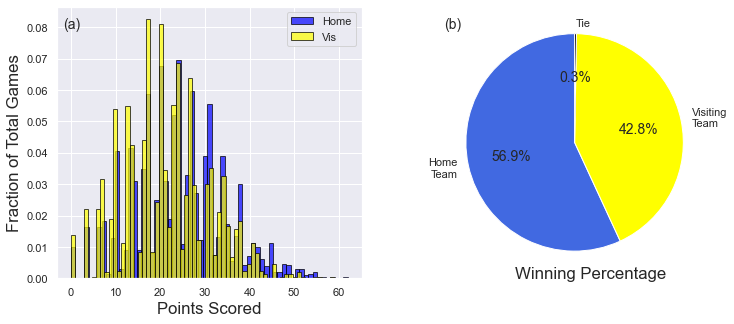

In [351]:
scores = extest[['H_Game','V_Game']].rename({'H_Game':'Home','V_Game':'Vis'},axis=1)
fig1 = plt.figure(figsize=(12,5))
ax1 = plt.subplot(1,2,1)
_ = plt.xlabel('Points Scored',fontsize='large')
_ = plt.ylabel('Fraction of Total Games',fontsize='large')
_ = plt.hist(scores['Home'],bins=63,density=True,color='blue',ec='black',alpha=0.7,
         label='Home')
_ = plt.hist(scores['Vis'],bins=63,density=True,color='yellow',ec='black',alpha=0.7,
         label='Vis')
_ = plt.legend(loc='upper right')
ax1.text(0.02,0.92,'(a)',transform=ax1.transAxes)
ax2 = plt.subplot(1,2,2)
win = np.array([(scores['Home'] > scores['Vis']).sum(),(scores['Home'] < scores['Vis']).sum(),
                 (scores['Home'] == scores['Vis']).sum()])
labels = 'Home'+'\n'+'Team', 'Visiting'+'\n'+'Team', 'Tie'
colors = ('royalblue','yellow','black')
_ = plt.pie(win/sum(win),labels=labels,autopct='%1.1f%%',radius=1.0,colors=colors,startangle=90)
_ = plt.text(0.28,0.00,'Winning Percentage',transform=ax2.transAxes,fontsize='large')
ax2.text(0.02,0.92,'(b)',transform=ax2.transAxes)
fig1.show()
fig1.savefig('plots/fig1.png',bbox_inches='tight')

**We can see the range of total score is much larger than that of the Over/Under (3X) with a positive correlation of 0.28.**

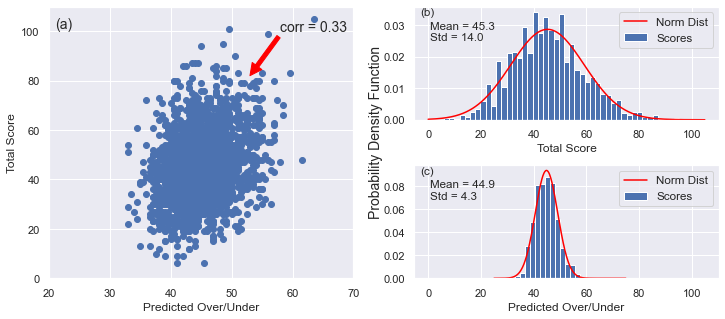

In [354]:
import matplotlib.gridspec as gridspec
from scipy import stats   

fig2 = plt.figure(figsize=(12,5))
outer = gridspec.GridSpec(1, 2, wspace=0.2, hspace=0.2)

inner_l = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=outer[0])
ax = plt.Subplot(fig2, inner_l[0])
ax.scatter(extest['Over/Under'],extest['Tot_Pts'])
ax.set_xlim((20,70))
ax.set_ylim((0,110))
ax.set_xlabel('Predicted Over/Under')
ax.set_ylabel('Total Score')
ax.annotate('corr = 0.33',xy=(53,82),xytext=(58,100),arrowprops={'color':'red'},fontsize='medium')
ax.text(0.02,0.92,'(a)',transform=ax.transAxes)

fig2.add_subplot(ax)

inner_r = gridspec.GridSpecFromSubplotSpec(2, 1,subplot_spec=outer[1],hspace=0.4)
j=0
mu = np.mean(extest['Tot_Pts'])
sig = np.std(extest['Tot_Pts'])
ax0 = plt.Subplot(fig2, inner_r[j])
ax0.set_xlabel('Total Score')
ax0.hist(extest['Tot_Pts'],bins=50,density=True,label='Scores')
xx = np.linspace(0,105,1000)
yy = stats.norm.pdf(xx,loc=mu,scale=sig)
ax0.plot(xx,yy,color='red',label='Norm Dist')
ax0.legend(loc='upper right',fontsize='small')
ax0.text(0.05,0.7,'Mean = {0:.1f}\nStd = {1:.1f}'.format(mu,sig),transform=ax0.transAxes,fontsize='small')
ax0.text(0.02,0.92,'(b)',transform=ax0.transAxes,fontsize='small')
fig2.add_subplot(ax0)
j=1
mu = np.mean(extest['Over/Under'])
sig = np.std(extest['Over/Under'])
ax1 = plt.Subplot(fig2, inner_r[j], sharex=ax0)
ax1.hist(extest['Over/Under'],bins=16,density=True,label='Scores')
xx = np.linspace(25,75,500)
yy = stats.norm.pdf(xx,loc=np.mean(extest['Over/Under']),scale=np.std(extest['Over/Under']))
ax1.plot(xx,yy,color='red',label='Norm Dist')
ax1.legend(loc='upper right',fontsize='small')
ax1.text(0.05,0.7,'Mean = {0:.1f}\nStd = {1:.1f}'.format(mu,sig),transform=ax1.transAxes,fontsize='small')
ax1.text(0.02,0.92,'(c)',transform=ax1.transAxes,fontsize='small')
fig2.add_subplot(ax1)
fig2.text(0.495,0.30,'Probability Density Function',rotation='vertical')
ax1.set_xlabel('Predicted Over/Under')
fig2.show()
fig2.savefig('plots/fig2.png',bbox_inches='tight')

In [355]:
error = extest['Tot_Pts'] - extest['Over/Under']

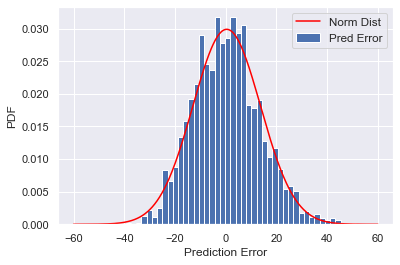

In [356]:
mu = np.mean(error)
sig = np.std(error)
xx = np.linspace(-60,60,500)
yy = stats.norm.pdf(xx,loc=mu,scale=sig)
fig3 = plt.figure()
_ = fig3.add_subplot(1,1,1)
_ = plt.xlabel('Prediction Error')
_ = plt.ylabel('PDF')
_ = plt.hist(error,bins=44,density=True,label='Pred Error')
_ = plt.plot(xx,yy,color='red',label='Norm Dist')
_ = plt.legend(loc='upper right',fontsize='small')
fig3.show()
fig3.savefig('plots/fig3.png',bbox_inches='tight')

**This boxplot shows the symmetry of the error data around 0 and the larger number of positive outliers in the Over/Under prediction error.** 

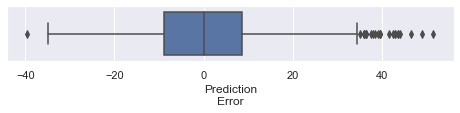

In [357]:
fig4 = plt.figure(figsize=(8,1))
error = pd.Series(error,name='Prediction'+'\n'+'Error')
_ = sns.boxplot(error, orient='h')
fig4.show()
fig4.savefig('plots/fig4.png',bbox_inches='tight')

**There is remarkable symmetry in the Over/Under prediction error, as well as in the Over vs. Under wins. This symmetry is also revealed in the median error, although a greater number of outliers to the upside is reflected in the average error.** 

The median and average errors for the Over are 9.0 and 11.1 points
The median and average errors for the Under are -9.0 and -10.3 points


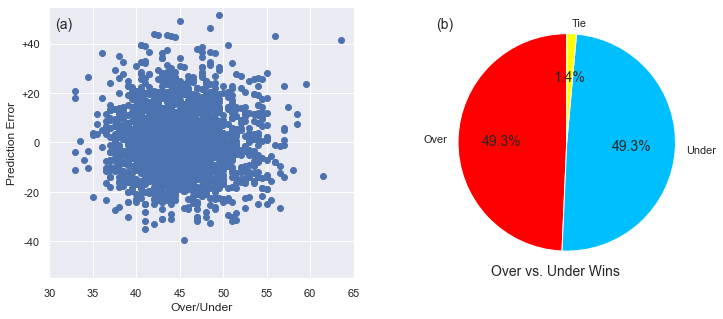

In [358]:
import matplotlib.ticker as tick
fig5, (ax1,ax2) = plt.subplots(1,2,figsize=(12,5)) 
error = extest['Tot_Pts'] - extest['Over/Under']
ax1.set_ylim(-55,55)
ax1.set_xlim(30,65)
ax1.set_xlabel('Over/Under')
ax1.set_ylabel('Prediction Error')
ax1.scatter(extest['Over/Under'],error)
def y_tk_fmt(x,y):
    if x > 0:
        return '{:+d}'.format(int(x))
    else:
        return '{:d}'.format(int(x))
ax1.yaxis.set_major_formatter(tick.FuncFormatter(y_tk_fmt))
ax1.text(0.02,0.92,'(a)',transform=ax1.transAxes,fontsize='medium')
o_u = np.array([(extest['Tot_Pts'] > extest['Over/Under']).sum(),
                (extest['Tot_Pts'] < extest['Over/Under']).sum(),
                 (extest['Tot_Pts'] == extest['Over/Under']).sum()])
labels = 'Over','Under','Tie'
colors = ('red','deepskyblue','yellow')
ax2.pie(o_u/sum(o_u),labels=labels,autopct='%1.1f%%',radius=1.0,colors=colors,
        startangle=90)
ax2.text(0.22,0.01,'Over vs. Under Wins',transform=ax2.transAxes)
ax2.text(0.02,0.92,'(b)',transform=ax2.transAxes,fontsize='medium')
fig5.show()
fig5.savefig('plots/fig5.png',bbox_inches='tight')
import statistics
pos = error[error > 0]
neg = error[error < 0]
print('The median and average errors for the Over are {0:.1f} and {1:.1f} points'
      .format(pos.median(),pos.mean()))
print('The median and average errors for the Under are {0:.1f} and {1:.1f} points'
      .format(neg.median(),neg.mean()))

In [359]:
Q3=error.quantile(0.75)
Q1=error.quantile(0.25)
IQR = Q3-Q1
outliers = extest.loc[error > 1.5*IQR,:]
outlier_year = pd.Series([int(x[0:4]) for x in outliers.index])
year_counts = outlier_year.value_counts().sort_index()

In [458]:
# Calculate percentage of 'Overs' by year 
year = pd.DataFrame([int(x[0:4]) for x in extest.index],columns = ['Year'],index=extest.index)
year['Over'] = extest['Tot_Pts'] > extest['Over/Under']
over_count = year['Over'].groupby(year.iloc[:,0]).mean()

In [461]:
year['Year'].value_counts()

2012    233
2017    228
2016    222
2018    219
2013    217
2019    214
2014    213
2015    211
2011    210
2010    195
Name: Year, dtype: int64

**There is no particular pattern with respect to number of outlier games and the year from the bar chart. Furthermore, the Over winning percentage is not constant by year, as shown in the line plot. However, there does seem to be some correlation between the Over winning percentage and the number of outlier games.** 

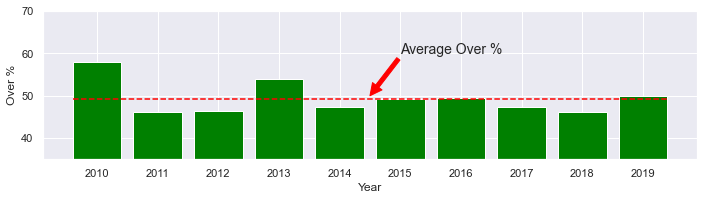

In [363]:
fig6 = plt.figure(figsize=(10,3))
_ = fig6.add_subplot(1,1,1)
_ = plt.xlabel('Year')
_ = plt.ylabel('Over %')
_ = plt.bar(year_counts.index,over_count.values*100,color='green',
       tick_label=[str(i) for i in range(2010,2020)])
_ = plt.ylim(35,70)
_ = plt.hlines(49.3,2009.6,2019.4,linestyle='dashed',colors='red')
_ = plt.annotate('Average Over %',xy=(2014.5,50),xytext=(2015,60),arrowprops={'color':'red'})
#ax2 = ax.twinx()
#ax2.set_ylabel('Number of Outlier Games')
#ax2.plot(over_count.index,over_count.values*100,linewidth=1, color='blue')
fig6.tight_layout()  
fig6.show()
fig6.savefig('plots/fig6.png')

In [689]:
over_means=bootstrap(extest['Tot_Pts']>extest['Over/Under'],195,np.mean)

mu = np.mean(over_means)
sd = np.std(over_means)
pct2_5 = np.percentile(over_means,2.5)
pct97_5 = np.percentile(over_means,97.5)
x = np.arange(pct2_5,pct97_5,0.001)
ymax = 14.0
y1 = ymax
y2 = 0.0
fig = plt.figure(figsize=(6,3))
ax = fig.add_subplot(1,1,1)
_ = plt.hist(over_means,bins=49,density=True,label='Seasonal mean Over%',zorder=1)
_ = plt.ylim(0,ymax)
ax.text(0.05,0.7,'Mean = {0:.3f}\nStd. Dev. = {1:.3f}'.format(mu,sd),transform=ax.transAxes,fontsize='small')
ax.text(0.05,0.2,'95% Conf. Int. =\n [{0:.3f},{1:.3f}]'.format(pct2_5,pct97_5),
                                                               transform=ax.transAxes,fontsize='small')
ax.fill_between(x, y1, y2,color='lightgreen',alpha=0.5)
_ = plt.vlines(pct2_5,0,ymax,color='red',alpha=0.8)
_ = plt.vlines(pct97_5,0,ymax,color='red',alpha=0.8)
_ = plt.scatter(over_count.values[0],0.4,marker='.',color='red',s=200,zorder=2)
ax. text(0.58,1.2,'2010 Over%',fontsize='small')
fig.tight_layout()
plt.show()

In [655]:
over_count.values[0]

0.5794871794871795

In [687]:
import scipy.stats
p = 1.0-stats.percentileofscore(over_means,over_count.values[0])/100
print(f'p-value is {p:.4f}')

p-value is 0.0055


**Examining the upside outlier games further, these games seem to be populated by certain scenarios. Here is a bar plot demonstrating the difference between the mean outlier value and the general mean value as a fraction of the general standard deviation for the categories in our dataset. Games that are poorly predicted to the upside seem to have some of the following characteristics in our dataset:**
 * Home teams having strong pass offenses, particularly those combined with weak visiting pass defenses, as reflected in "H_Pass_Metric" 
 * Home teams with a strong tendency to obtain turnovers
 * Home teams with high red zone percentages against teams with low red zone percentages
 * Visiting teams with penchant for incurring penalties

**The following correlation matrix reveals that there seems to be a much greater correlation between the scoring history of the teams and the predicted over/under (0.45,0.46) than between the scoring history and the actual total score of the predicted game (0.14,0.13). In addition, there is little to no correlation between the opposing teams' scores of the last five games and the total score of the game in question (0.00,0.05). Also revealed is that there is significant correlation between red zone percentage and scoring history, as expected, but little correlation with scoring history and field goal percentage. The importance of red zone percentage is reflected in the over/under prediction, but less so in the actual total score.**

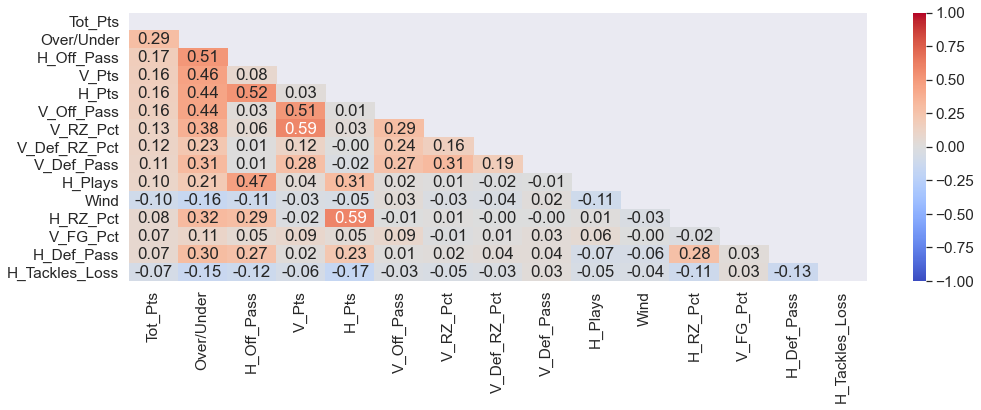

In [811]:
fig7 = plt.figure(figsize=(15,6))
ax = fig7.add_subplot(1,1,1)

cols = X_show.columns.drop(['Home_Team','Vis_Team','H_Game','V_Game'])
#cols = cols.drop(['a_turf','astroplay','astroturf','fieldturf','grass','matrixturf','sportturf'])
corrs = [np.abs(X_show['Tot_Pts'].corr(X_show[col])) for col in cols]
sortcorr = sorted(corrs,reverse=True)
mapa = {ind:corrs.index(value) for ind,value in enumerate(sortcorr)}
newcols = [cols[mapa[ind]] for ind in range(len(cols))]

Top = X_show[newcols[0:15]]
mask = np.triu(Top.corr())
sns.set(font_scale=1.4)
sns.heatmap(Top.corr(),vmin=-1.0,center=0,vmax=1.0,mask=mask,
            annot=True,cmap='coolwarm',fmt='.2f')
#_ = plt.text(0.95,0.92,'(a)',transform=ax.transAxes,fontsize='medium')
fig7.tight_layout()
fig7.show()
fig7.savefig('plots/fig7.png')

In [456]:
X_show['Tot_Pts'].corr(X_show['H_Def_RZ_Pct'])

0.051472387657170736

In [457]:
X_show['Over/Under'].corr(X_show['H_Def_RZ_Pct'])

0.20440976755338705

In [542]:
X_show = X_show.drop(['H_TD','V_TD'],axis=1)

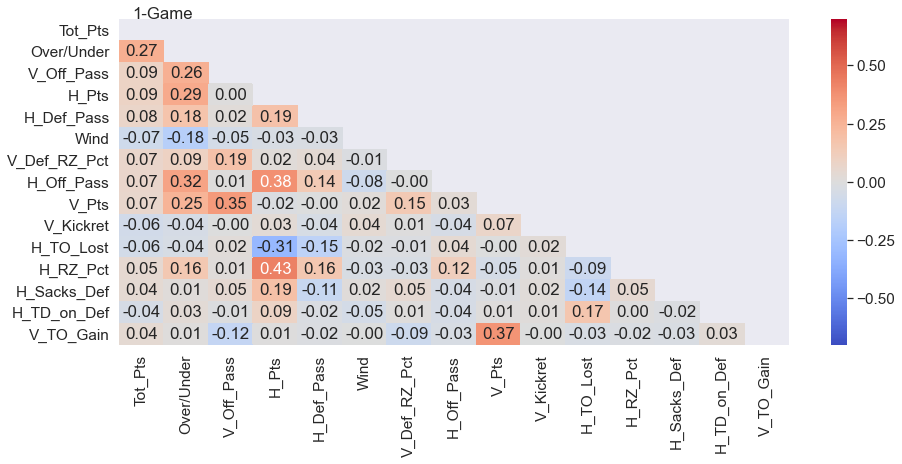

In [543]:
fig8 = plt.figure(figsize=(15,6))
ax = fig8.add_subplot(1,1,1)

cols = X_show.columns.drop(['Home_Team','Vis_Team','H_Game','V_Game'])
cols = cols.drop(['a_turf','astroplay','astroturf','fieldturf','grass','matrixturf','sportturf'])
corrs = [np.abs(X_show['Tot_Pts'].corr(X_show[col])) for col in cols]
sortcorr = sorted(corrs,reverse=True)
mapa = {ind:corrs.index(value) for ind,value in enumerate(sortcorr)}
newcols = [cols[mapa[ind]] for ind in range(len(cols))]

Top = X_show[newcols[0:15]]
mask = np.triu(Top.corr())
sns.set(font_scale=1.4)
sns.heatmap(Top.corr(),vmin=-1.0,center=0,vmax=1.0,mask=mask,
            annot=True,cmap='coolwarm',fmt='.2f')
_ = plt.text(0.02,1.00,str(num)+'-Game',transform=ax.transAxes)
fig8.show()
file = 'plots/fig8_'+str(num)+'.png'
fig8.savefig(file)

In [1080]:
X_show[X_show['Humidity'] > 0].Temperature.min()

-8.60381222818219

In [278]:
len(notdomed[((notdomed['Humidity']>0) & (notdomed['Temperature']>78))])

24

In [279]:
notdomed[notdomed['Humidity']>0].Temperature.max()

87.0

In [280]:
notdomed['Tot_Pts'].corr(notdomed['Humidity'])

-0.01693180585799956

In [281]:
notdomed[notdomed['Humidity']>0]['Tot_Pts'].corr(notdomed['Humidity'])

-0.04514612409621939

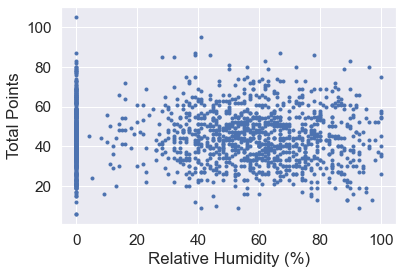

In [818]:
_ = plt.plot(notdomed['Humidity'],notdomed['Tot_Pts'],marker='.',linestyle='None')
_ = plt.xlabel('Relative Humidity (%)')
_ = plt.ylabel('Total Points')
plt.show()

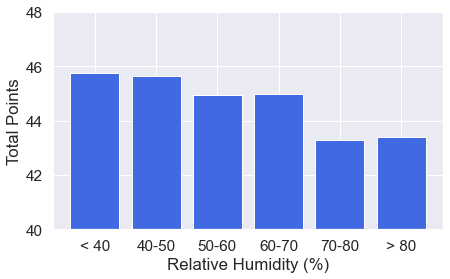

In [820]:
fig77 = plt.figure(figsize=(7,4))
bins = [0,40,50,60,70,80,100]
grouped = extest.groupby(pd.cut(extest.Humidity,bins))
# counts = grouped['Tot_Pts'].count().values
# alp = counts/max(counts)
# colors = [(0,0,0.5,alp[a]) for a in range(len(alp))]
ind = np.arange(len(grouped['Humidity'].mean()))
_ = plt.bar(ind,grouped['Tot_Pts'].mean().values,color='royalblue')
_ = plt.xticks(ind,labels=('< 40','40-50','50-60','60-70','70-80','> 80'))
_ = plt.ylim(40,48)
_ = plt.xlabel('Relative Humidity (%)')
_ = plt.ylabel('Total Points')
fig.tight_layout()
plt.show()
fig77.savefig('plots/fig77.png')

In [817]:
grouped['Tot_Pts'].count()

Humidity
(0, 40]      188
(40, 50]     171
(50, 60]     234
(60, 70]     196
(70, 80]     152
(80, 100]    153
Name: Tot_Pts, dtype: int64

In [296]:
X_show['Tot_Pts'].corr(X_show['Temperature'])

0.060583849681406454

In [297]:
notdomed['Tot_Pts'].corr(notdomed['Temperature'])

0.04175134613588856

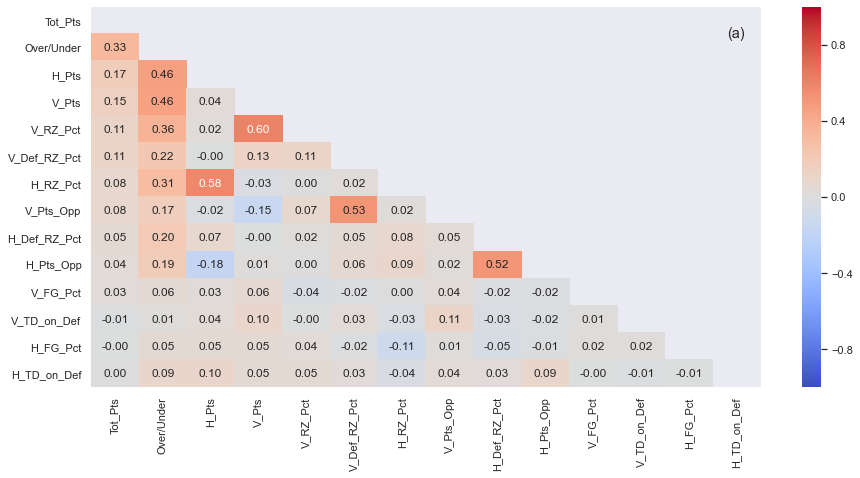

In [618]:
fig9a = plt.figure(figsize=(15,7))
ax = fig9a.add_subplot(1,1,1)

cols=['Over/Under','Tot_Pts','H_Pts','H_Pts_Opp','V_Pts','V_Pts_Opp','H_TD_on_Def','V_TD_on_Def',
      'H_RZ_Pct','V_RZ_Pct','H_Def_RZ_Pct','V_Def_RZ_Pct','H_FG_Pct','V_FG_Pct']
corrs = [np.abs(X_show['Tot_Pts'].corr(X_show[col])) for col in cols]
sortcorr = sorted(corrs,reverse=True)
mapa = {ind:corrs.index(value) for ind,value in enumerate(sortcorr)}
newcols = [cols[mapa[ind]] for ind in range(len(cols))] 

Points = X_show[newcols]
mask = np.triu(Points.corr())
sns.heatmap(Points.corr(),vmin=-1.0,center=0,vmax=1.0,mask=mask,
            annot=True,cmap='coolwarm',fmt='.2f')
_ = plt.text(0.95,0.92,'(a)',transform=ax.transAxes,fontsize='large')
fig9a.show()
fig9a.savefig('plots/fig9a.png')

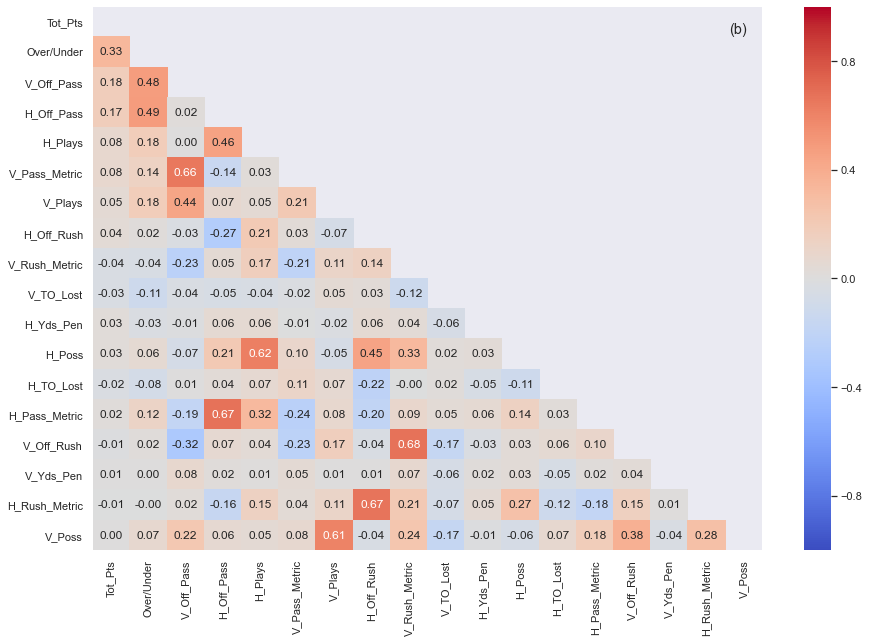

In [617]:
fig9b = plt.figure(figsize=(15,10))
ax = fig9b.add_subplot(1,1,1)

cols=['Over/Under','Tot_Pts','H_Off_Pass','H_Pass_Metric','V_Off_Pass',
              'V_Pass_Metric','H_Off_Rush','H_Rush_Metric','V_Off_Rush',
              'V_Rush_Metric','H_TO_Lost','V_TO_Lost','H_Yds_Pen','V_Yds_Pen',
              'H_Poss','V_Poss','H_Plays','V_Plays']
corrs = [np.abs(X_show['Tot_Pts'].corr(X_show[col])) for col in cols]
sortcorr = sorted(corrs,reverse=True)
mapa = {ind:corrs.index(value) for ind,value in enumerate(sortcorr)}
newcols = [cols[mapa[ind]] for ind in range(len(cols))] 

Ostats=X_show[newcols]
mask = np.triu(Ostats.corr())
sns.heatmap(Ostats.corr(),vmin=-1.0,center=0,vmax=1.0,mask=mask,
            annot=True,cmap='coolwarm',fmt='.2f')
_ = plt.text(0.95,0.95,'(b)',transform=ax.transAxes,fontsize='large')
fig9b.show()
fig9b.savefig('plots/fig9b.png')

In [370]:
X_show['H_Pts'].corr(X_show['H_Pass_Metric'])

0.3432109770983537

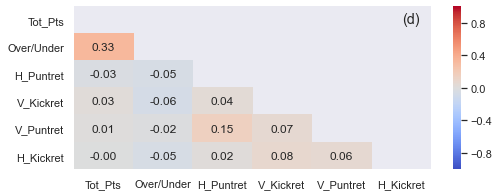

In [615]:
fig9d = plt.figure(figsize=(8,3))
ax = fig9d.add_subplot(1,1,1)

cols=['Tot_Pts','Over/Under','H_Kickret','V_Kickret',
              'H_Puntret','V_Puntret']
corrs = [np.abs(X_show['Tot_Pts'].corr(X_show[col])) for col in cols]
sortcorr = sorted(corrs,reverse=True)
mapa = {ind:corrs.index(value) for ind,value in enumerate(sortcorr)}
newcols = [cols[mapa[ind]] for ind in range(len(cols))] 

Sstats=X_show[newcols]
mask = np.triu(Sstats.corr())
sns.heatmap(Sstats.corr(),vmin=-1.0,center=0,vmax=1.0,mask=mask,
            annot=True,cmap='coolwarm',fmt='.2f')
_ = plt.text(0.92,0.90,'(d)',transform=ax.transAxes,fontsize='large')
fig9d.show()
fig9d.savefig('plots/fig9d.png')

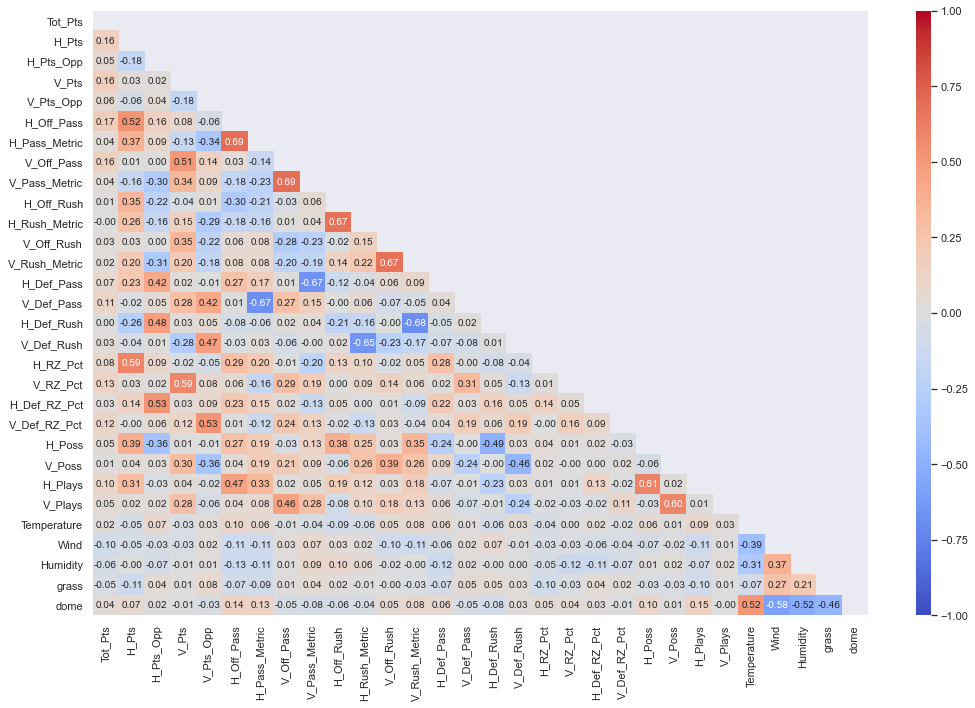

In [807]:
fig9 = plt.figure(figsize=(15,10))
ax = fig9.add_subplot(1,1,1)

dropped = ['Home_Team','Vis_Team','H_Game','V_Game','Over/Under']
                 
cols=X_show.columns.drop(dropped)
#corrs = [np.abs(X_show['Tot_Pts'].corr(X_show[col])) for col in cols]
#sortcorr = sorted(corrs,reverse=True)
#mapa = {ind:corrs.index(value) for ind,value in enumerate(sortcorr)}
#newcols = [cols[mapa[ind]] for ind in range(len(cols))] 

Stats=X_show[cols]
coeffs = Stats.corr()
moretodrop = []
for col in cols:
    if (col != 'Tot_Pts'):
        max_coef = coeffs.loc[col,np.abs(coeffs.loc[col]).rank(ascending=False) == 2].values[0] # neglect self-correlation
        if np.abs(max_coef) < 0.4: moretodrop.append(col)
coeffs = coeffs.drop(moretodrop).drop(moretodrop,axis=1)
mask = np.triu(coeffs)
#sns.set(font_scale=0.8)
sns.set(font_scale=1.0)
sns.heatmap(coeffs,vmin=-1.0,center=0,vmax=1.0,mask=mask,
            annot=True,cmap='coolwarm',cbar_kws={'aspect':40},fmt='.2f',annot_kws={"size": 10})
fig9.tight_layout()
fig9.show()
fig9.savefig('plots/fig9.png')

In [16]:
LR = linear_model.LinearRegression()

In [21]:
standard = StandardScaler()
robust = RobustScaler()

In [298]:
# Without Over/Under
rmse = np.empty(7)
bench_rmse = np.empty(7)
rmse_ext = np.empty(7)
bench_rmse_ext = np.empty(7)
acc = np.empty(7)
acc_ext = np.empty(7)
for n in range(1,8):
    path = 'data/df_working'+str(n)+'.pkl'
    with open(path,'rb') as f:
        dfgame = pickle.load(f)
    yy = np.ravel(dfgame['Tot_Pts'])
    XX = dfgame.drop(['Tot_Pts','Over/Under','Home_Team','Vis_Team','H_Game','V_Game'],axis=1)
    XX_train, XX_test, yy_train, yy_test = train_test_split(XX, yy, test_size = 1-train_ratio, random_state=77)
    XX_val, XX_test, yy_val, yy_test = train_test_split(XX_test, yy_test, 
                                                test_size = test_ratio/(test_ratio + validation_ratio), random_state=77)
    sca_train = robust.fit_transform(XX_train)
    sca_test = robust.transform(XX_test)
    LR.fit(sca_train,yy_train)
    yy_pred=pd.Series(LR.predict(sca_test))
    ou = dfgame.loc[XX_test.index,'Over/Under']
    rmse[n-1] = mean_squared_error(yy_test,yy_pred,squared=False)
    bench_rmse[n-1] = mean_squared_error(yy_test,ou,squared=False)
    results = pd.DataFrame(yy_test,columns=['Actual'],index=XX_test.index)
    results['Predicted'] = yy_pred.values
    results['Over/Under'] = ou
    corr = (((results['Actual']<results['Over/Under']) & (results['Predicted']<results['Over/Under'])).sum() +
            ((results['Actual']>results['Over/Under']) & (results['Predicted']>results['Over/Under'])).sum())
    tot = (results['Actual']<results['Over/Under']).sum() + (results['Actual']>results['Over/Under']).sum()
    acc[n-1] = corr/tot
    ext = results[np.abs(results['Predicted']-results['Over/Under']) >= 3.0]
    corr = (((ext['Actual']<ext['Over/Under']) & (ext['Predicted']<ext['Over/Under'])).sum() +
            ((ext['Actual']>ext['Over/Under']) & (ext['Predicted']>ext['Over/Under'])).sum())
    tot = (ext['Actual']<ext['Over/Under']).sum() + (ext['Actual']>ext['Over/Under']).sum()
    acc_ext[n-1] = corr/tot
    rmse_ext[n-1] = mean_squared_error(ext['Actual'],ext['Predicted'],squared=False)
    bench_rmse_ext[n-1] = mean_squared_error(ext['Actual'],ext['Over/Under'],squared=False)
print(rmse)
print(acc)

[14.56935351 13.61006849 12.92559276 13.35868523 14.34657835 13.48488739
 13.77291085]
[0.46418338 0.50598802 0.52922078 0.5122807  0.48449612 0.52765957
 0.4784689 ]


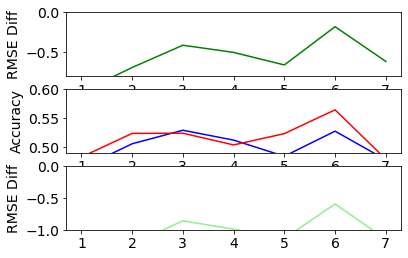

In [143]:
fig8 = plt.figure()
_ = fig8.add_subplot(3,1,1)
_ = plt.xlabel('# Games Averaged')
_ = plt.ylabel('RMSE Diff')
_ = plt.ylim(-0.8,0)
#_ = plt.plot(np.arange(1,len(rmse)+1),rmse,color='blue')
#_ = plt.plot(np.arange(1,len(rmse)+1),bench_rmse,color='red')
_ = plt.plot(np.arange(1,len(rmse)+1),bench_rmse-rmse,color='green')
_ = fig8.add_subplot(3,1,2)
#_ = plt.xlabel('# Games Averaged')
_ = plt.ylabel('Accuracy')
_ = plt.ylim(0.49,0.60)
_ = plt.plot(np.arange(1,len(acc)+1),acc,color='blue')
_ = plt.plot(np.arange(1,len(acc)+1),acc_ext,color='red')
_ = fig8.add_subplot(3,1,3)
_ = plt.ylabel('RMSE Diff')
_ = plt.plot(np.arange(1,len(acc)+1),bench_rmse_ext-rmse_ext,color='lightgreen')
_ = plt.ylim(-1.0,-0.0)
fig8.show()
#fig8.savefig('plots/fig8.png')

[14.15533066 13.17465049 12.81817783 13.19301357 14.23080156 13.32890885
 13.60503085]
[0.46704871 0.50898204 0.50649351 0.47017544 0.48837209 0.51914894
 0.44976077]


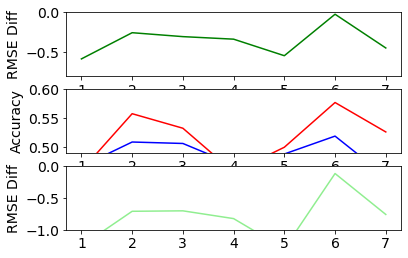

In [299]:
# With Over/Under
for n in range(1,8):
    path = 'data/df_working'+str(n)+'.pkl'
    with open(path,'rb') as f:
        dfgame = pickle.load(f)
    yy = np.ravel(dfgame['Tot_Pts'])
    XX = dfgame.drop(['Tot_Pts','Home_Team','Vis_Team','H_Game','V_Game'],axis=1)
    XX_train, XX_test, yy_train, yy_test = train_test_split(XX, yy, test_size = 1-train_ratio, random_state=77)
    XX_val, XX_test, yy_val, yy_test = train_test_split(XX_test, yy_test, 
                                                test_size = test_ratio/(test_ratio + validation_ratio), random_state=77)
    sca_train = robust.fit_transform(XX_train)
    sca_test = robust.transform(XX_test)
    LR.fit(sca_train,yy_train)
    yy_pred=pd.Series(LR.predict(sca_test))
    ou = dfgame.loc[XX_test.index,'Over/Under']
    rmse[n-1] = mean_squared_error(yy_test,yy_pred,squared=False)
    bench_rmse[n-1] = mean_squared_error(yy_test,ou,squared=False)
    results = pd.DataFrame(yy_test,columns=['Actual'],index=XX_test.index)
    results['Predicted'] = yy_pred.values
    results['Over/Under'] = ou
    corr = (((results['Actual']<results['Over/Under']) & (results['Predicted']<results['Over/Under'])).sum() +
            ((results['Actual']>results['Over/Under']) & (results['Predicted']>results['Over/Under'])).sum())
    tot = (results['Actual']<results['Over/Under']).sum() + (results['Actual']>results['Over/Under']).sum()
    acc[n-1] = corr/tot
    ext = results[np.abs(results['Predicted']-results['Over/Under']) >= 3.0]
    corr = (((ext['Actual']<ext['Over/Under']) & (ext['Predicted']<ext['Over/Under'])).sum() +
            ((ext['Actual']>ext['Over/Under']) & (ext['Predicted']>ext['Over/Under'])).sum())
    tot = (ext['Actual']<ext['Over/Under']).sum() + (ext['Actual']>ext['Over/Under']).sum()
    acc_ext[n-1] = corr/tot
    rmse_ext[n-1] = mean_squared_error(ext['Actual'],ext['Predicted'],squared=False)
    bench_rmse_ext[n-1] = mean_squared_error(ext['Actual'],ext['Over/Under'],squared=False)
fig8a = plt.figure()
_ = fig8a.add_subplot(3,1,1)
_ = plt.xlabel('# Games Averaged')
_ = plt.ylabel('RMSE Diff')
_ = plt.ylim(-0.8,-0)
_ = plt.plot(np.arange(1,len(rmse)+1),bench_rmse-rmse,color='green')
_ = fig8a.add_subplot(3,1,2)
_ = plt.ylabel('Accuracy')
_ = plt.ylim(0.49,0.60)
_ = plt.plot(np.arange(1,len(acc)+1),acc,color='blue')
_ = plt.plot(np.arange(1,len(acc)+1),acc_ext,color='red')
_ = fig8a.add_subplot(3,1,3)
_ = plt.ylabel('RMSE Diff')
_ = plt.plot(np.arange(1,len(acc)+1),bench_rmse_ext-rmse_ext,color='lightgreen')
_ = plt.ylim(-1.0,-0.0)
print(rmse)
print(acc)
fig8a.show()

In [144]:
bench_rmse

array([13.57318128, 12.92017042, 12.51460685, 12.85773808, 13.6885513 ,
       13.30544842, 13.15957934])

In [796]:
X = dfgame.drop(['Tot_Pts','Home_Team','Vis_Team','H_Game','V_Game'],axis=1)

In [799]:
# With Over/Under
path = 'data/df_working6.pkl'
with open(path, 'rb') as f:
    dfgame = pickle.load(f)
X = dfgame.drop(['Tot_Pts','Home_Team','Vis_Team','H_Game','V_Game'],axis=1)
X = X.drop(turf,axis=1)
y = dfgame['Tot_Pts'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1-train_ratio, random_state=77)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, 
                                                test_size = test_ratio/(test_ratio + validation_ratio),
                                                random_state=77)
sca_train = robust.fit_transform(X_train)
sca_test = robust.transform(X_test)
LR.fit(sca_train,y_train)
y_pred=LR.predict(sca_test)
metric=mean_squared_error(y_test,y_pred,squared=False)
ou = dfgame.loc[X_test.index,'Over/Under']
results = pd.DataFrame(y_test,columns=['Actual'],index=X_test.index)
results['Predicted'] = y_pred
results['Over/Under'] = ou
corr = (((results['Actual']<results['Over/Under']) & (results['Predicted']<results['Over/Under'])).sum() +
        ((results['Actual']>results['Over/Under']) & (results['Predicted']>results['Over/Under'])).sum())
tot = (results['Actual']<results['Over/Under']).sum() + (results['Actual']>results['Over/Under']).sum()
acc = corr/tot
print(f'RMSE = {metric:.3f}, Accuracy = {acc:.3f}')
coef = pd.DataFrame(LR.coef_, X_train.columns, columns=['LR Coefficient'])
ind=np.flip(np.argsort(abs(LR.coef_)))
print(coef.iloc[ind])

RMSE = 13.312, Accuracy = 0.511
                LR Coefficient
Over/Under            5.256600
V_Def_Rush            2.557634
Wind                 -2.493557
V_Off_Pass            2.164910
dome                 -2.050603
V_Pass_Metric        -1.730109
H_Pass_Metric        -1.642918
H_Pts                 1.615141
V_Pts_Opp            -1.395575
H_Def_Pass           -1.368650
H_Sacks_Def           1.367725
H_Off_Pass            1.305385
V_Def_RZ_Pct          1.161555
V_Kickret             1.045589
H_Rush_Metric         1.030868
V_Tackles_Loss        1.006342
H_RZ_Pct             -0.995086
H_Yds_Pen             0.821427
V_TO_Lost             0.805421
H_FG_Pct             -0.710033
H_TD_on_Def          -0.684491
H_Poss               -0.652836
H_Plays               0.594161
H_Def_Rush            0.581268
V_Def_Pass            0.576725
V_Off_Rush            0.554450
grass                -0.551513
V_Puntret             0.532467
V_Rush_Metric        -0.506684
V_Pts                -0.494131
H_TO_Ga

In [791]:
# W/out Over/Under
# path = 'data/df_working6.pkl'
# with open(path, 'rb') as f:
#     dfgame = pickle.load(f)
# X = dfgame.drop(['Tot_Pts','Over/Under','Home_Team','Vis_Team','H_Game','V_Game'],axis=1)
# y = dfgame['Tot_Pts'].values
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1-train_ratio, random_state=77)
# X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, 
#                                                 test_size = test_ratio/(test_ratio + validation_ratio),
#                                                 random_state=77)
X = dfgame.drop('Over/Under',axis=1)
sca_train = robust.fit_transform(X_train)
sca_test = robust.transform(X_test)
LR.fit(sca_train,y_train)
y_pred=LR.predict(sca_test)
metric=mean_squared_error(y_test,y_pred,squared=False)
ou = dfgame.loc[X_test.index,'Over/Under']
results = pd.DataFrame(y_test,columns=['Actual'],index=X_test.index)
results['Predicted'] = y_pred
results['Over/Under'] = ou
corr = (((results['Actual']<results['Over/Under']) & (results['Predicted']<results['Over/Under'])).sum() +
        ((results['Actual']>results['Over/Under']) & (results['Predicted']>results['Over/Under'])).sum())
tot = (results['Actual']<results['Over/Under']).sum() + (results['Actual']>results['Over/Under']).sum()
acc = corr/tot
print(f'RMSE = {metric:.3f}, Accuracy = {acc:.3f}')
coef = pd.DataFrame(LR.coef_, X_train.columns, columns=['LR Coefficient'])
ind=np.flip(np.argsort(abs(LR.coef_)))
coef_sort = coef.iloc[ind]
print(coef_sort)

RMSE = 13.664, Accuracy = 0.488
                LR Coefficient
V_Off_Pass            5.113253
V_Pass_Metric        -3.938805
H_Pts                 3.139118
H_Def_Pass           -2.778140
V_Def_Rush            2.640758
Wind                 -2.304422
H_Pts_Opp             2.302224
H_Off_Pass            2.015714
V_Def_RZ_Pct          1.828499
H_Def_RZ_Pct         -1.731947
H_Rush_Metric         1.327353
V_Pts_Opp            -1.297141
dome                 -1.262283
Humidity             -1.200912
H_Pass_Metric        -1.167087
V_TO_Lost             1.152670
V_Pts                 1.119034
V_Tackles_Loss        1.106813
V_Def_Pass            1.067927
H_TD_on_Def          -1.040449
V_FG_Pct              0.993500
H_RZ_Pct             -0.874202
H_FG_Pct             -0.844133
V_Off_Rush            0.744700
Week                 -0.721429
V_Puntret             0.660872
H_Yds_Pen             0.659902
V_RZ_Pct              0.600573
H_Off_Rush           -0.568580
V_Sacks_Def           0.567702
H_Plays

In [188]:
smallcols = coef_sort[abs(coef_sort['LR Coefficient']) > 0.1*abs(coef_sort.iloc[0,0])].index
X = dfgame[smallcols]
y = dfgame['Tot_Pts'].values
small_train,small_test,y_train,y_test=train_test_split(X, y, test_size = 1-train_ratio, random_state=77)
small_val,small_test,y_val,y_test=train_test_split(small_test, y_test,
                                                   test_size = test_ratio/(test_ratio + validation_ratio),
                                                   random_state=77)
sca_train = robust.fit_transform(small_train)
sca_test = robust.transform(small_test)
LR.fit(sca_train,y_train)
y_pred=LR.predict(sca_test)
metric=mean_squared_error(y_test,y_pred,squared=False)
ou = dfgame.loc[small_test.index,'Over/Under']
results = pd.DataFrame(y_test,columns=['Actual'],index=small_test.index)
results['Predicted'] = y_pred
results['Over/Under'] = ou
corr = (((results['Actual']<results['Over/Under']) & (results['Predicted']<results['Over/Under'])).sum() +
        ((results['Actual']>results['Over/Under']) & (results['Predicted']>results['Over/Under'])).sum())
tot = (results['Actual']<results['Over/Under']).sum() + (results['Actual']>results['Over/Under']).sum()
acc = corr/tot
print(f'RMSE = {metric:.3f} Accuracy = {acc:.3f}')
coef = pd.DataFrame(LR.coef_, small_train.columns, columns=['LR Coefficient'])
ind=np.flip(np.argsort(abs(LR.coef_)))
coef_sort = coef.iloc[ind]
print(coef_sort)

RMSE = 13.444 Accuracy = 0.574
                LR Coefficient
matrixturf            4.931307
astroplay            -4.175741
H_Off_Pass            3.692867
V_Def_Rush            2.881447
V_Off_Pass            2.634838
Wind                 -2.563173
dome                 -2.422679
H_Pts                 2.181122
H_Pass_Metric        -1.847054
H_Def_Rush            1.614202
sportturf             1.437851
V_Def_RZ_Pct          1.334762
V_Pts_Opp            -1.329678
H_Sacks_Def           1.205163
V_Pts                 1.171105
V_Pass_Metric        -0.995371
V_Kickret             0.977535
grass                -0.896971
H_Rush_Metric         0.891654
V_Tackles_Loss        0.883233
H_RZ_Pct             -0.839294
V_TO_Lost             0.750520
H_Yds_Pen             0.742614
V_RZ_Pct              0.709164
V_Def_Pass            0.702125
H_TO_Gain            -0.696489
Temperature           0.696468
H_Off_Rush            0.691177
H_FG_Pct             -0.629520
H_Poss               -0.431499


In [177]:
LR.intercept_

44.34477041641476

In [189]:
# W/out Over/Under
#X = pd.concat([dfgame.drop(['Tot_Pts','Over/Under','Home_Team','Vis_Team','H_Game','V_Game','Over/Under'],axis=1),
#            pd.get_dummies(dfgame.Home_Team,drop_first=True)],axis=1)
X = pd.concat([dfgame[smallcols],pd.get_dummies(dfgame.Home_Team,drop_first=True)],axis=1)
y = dfgame['Tot_Pts'].values
stad_train, stad_test, y_train, y_test = train_test_split(X, y, test_size = 1-train_ratio, random_state=77)
stad_val, stad_test, y_val, y_test = train_test_split(stad_test, y_test, 
                                                test_size = test_ratio/(test_ratio + validation_ratio),
                                                random_state=77)
sca_train = robust.fit_transform(stad_train)
sca_test = robust.transform(stad_test)
LR.fit(sca_train,y_train)
y_pred=LR.predict(sca_test)
metric=mean_squared_error(y_test,y_pred,squared=False)
ou = dfgame.loc[stad_test.index,'Over/Under']
results = pd.DataFrame(y_test,columns=['Actual'],index=stad_test.index)
results['Predicted'] = y_pred
results['Over/Under'] = ou
corr = (((results['Actual']<results['Over/Under']) & (results['Predicted']<results['Over/Under'])).sum() +
        ((results['Actual']>results['Over/Under']) & (results['Predicted']>results['Over/Under'])).sum())
tot = (results['Actual']<results['Over/Under']).sum() + (results['Actual']>results['Over/Under']).sum()
acc = corr/tot
print(f'RMSE = {metric:.3f}, Accuracy = {acc:.3f}')
coef = pd.DataFrame(LR.coef_, stad_train.columns, columns=['LR Coefficient'])
ind=np.flip(np.argsort(abs(LR.coef_)))
coef_sort = coef.iloc[ind]
print(coef_sort[0:43])
print(coef_sort[43:])

RMSE = 13.531, Accuracy = 0.553
                      LR Coefficient
astroplay                 -13.460900
St. Louis Rams             10.790756
New Orleans Saints          8.043377
Los Angeles Rams            7.702040
Oakland Raiders             6.314679
Kansas City Chiefs         -5.311106
New England Patriots        4.963151
Los Angeles Chargers       -4.713996
matrixturf                  4.056538
Cincinnati Bengals          3.939965
Green Bay Packers           3.830971
H_Off_Pass                  3.768530
sportturf                  -3.671043
Houston Texans             -3.495844
Minnesota Vikings           3.299875
V_Def_Rush                  3.148257
Miami Dolphins              2.988284
Washington Redskins         2.967138
Baltimore Ravens            2.792210
V_Off_Pass                  2.459538
Wind                       -2.381919
H_Pass_Metric              -2.309023
H_Pts                       2.218547
Tennessee Titans            2.124317
San Diego Chargers          2.030958
Indian

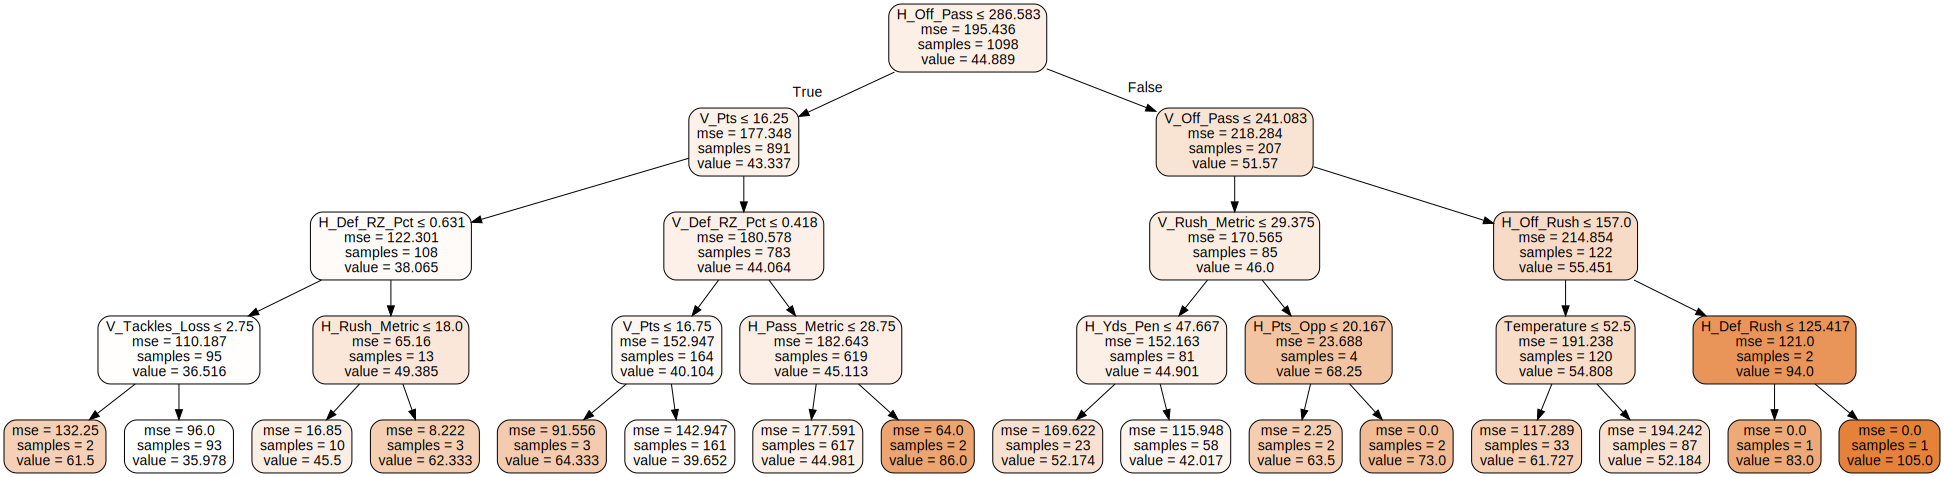

In [211]:
# No Over/Under -- Decision Tree
from sklearn import tree, metrics
import graphviz
X = dfgame.drop(['Tot_Pts','Over/Under','Home_Team','Vis_Team','H_Game','V_Game'],axis=1)
y = dfgame['Tot_Pts'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1-train_ratio, random_state=77)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, 
                                                test_size = test_ratio/(test_ratio + validation_ratio),
                                                random_state=77)
tree_model=tree.DecisionTreeRegressor(random_state=77,max_depth=4)
tree_model.fit(X_train,y_train)
y_pred = tree_model.predict(X_test) 
dot_data=tree.export_graphviz(tree_model, filled=True, rounded=True,
                                     special_characters=True,feature_names=X_train.columns,
                                     class_names=tree_model.classes_)
graphviz.Source(dot_data)

In [212]:
metric=mean_squared_error(y_test,y_pred,squared=False)
ou = dfgame.loc[X_test.index,'Over/Under']
results = pd.DataFrame(y_test,columns=['Actual'],index=X_test.index)
results['Predicted'] = y_pred
results['Over/Under'] = ou
corr = (((results['Actual']<results['Over/Under']) & (results['Predicted']<results['Over/Under'])).sum() +
        ((results['Actual']>results['Over/Under']) & (results['Predicted']>results['Over/Under'])).sum())
tot = (results['Actual']<results['Over/Under']).sum() + (results['Actual']>results['Over/Under']).sum()
acc = corr/tot
print(f'RMSE = {metric:.3f}, Accuracy = {acc:.3f}')

RMSE = 15.134, Accuracy = 0.481


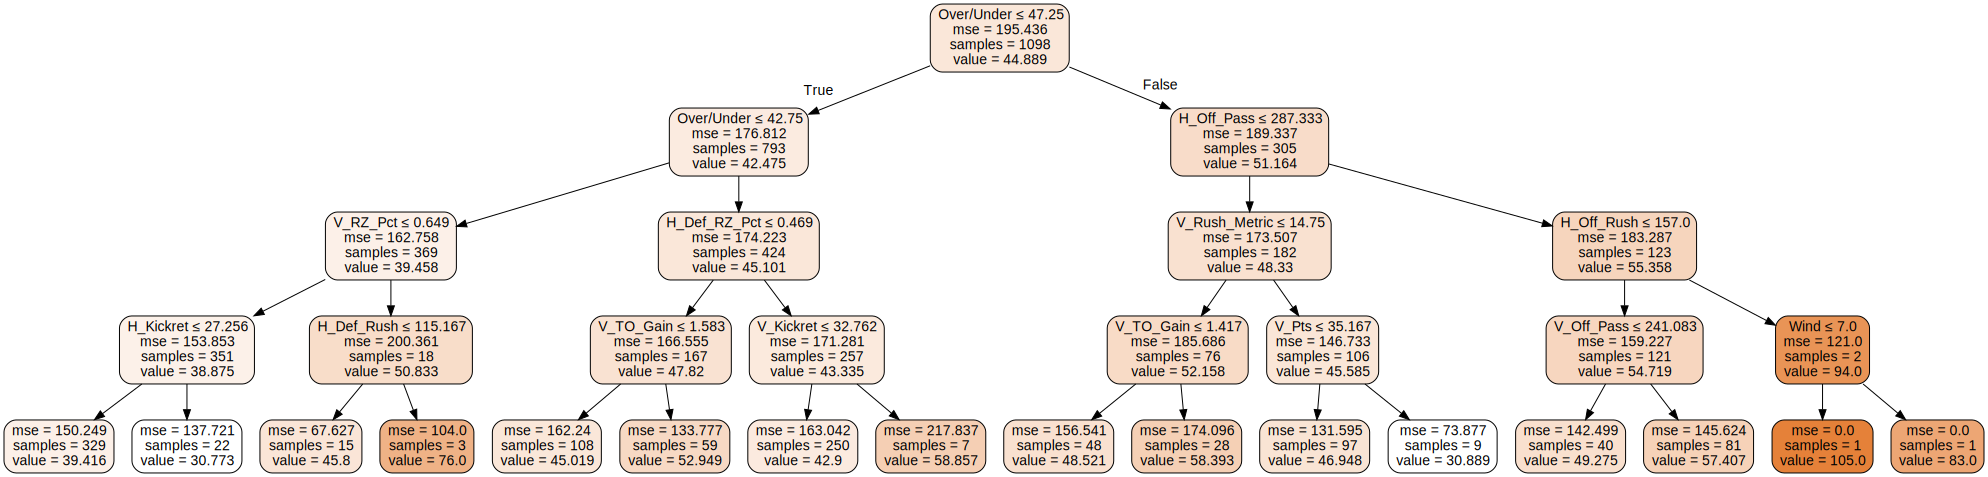

In [214]:
# Over/Under -- Decision Tree
from sklearn import tree, metrics
import graphviz
X = dfgame.drop(['Tot_Pts','Home_Team','Vis_Team','H_Game','V_Game'],axis=1)
y = dfgame['Tot_Pts'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1-train_ratio, random_state=77)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, 
                                                test_size = test_ratio/(test_ratio + validation_ratio),
                                                random_state=77)
tree_model=tree.DecisionTreeRegressor(random_state=77,max_depth=4)
tree_model.fit(X_train,y_train)
y_pred = tree_model.predict(X_test) 
dot_data=tree.export_graphviz(tree_model, filled=True, rounded=True,
                                     special_characters=True,feature_names=X_train.columns)
graphviz.Source(dot_data)

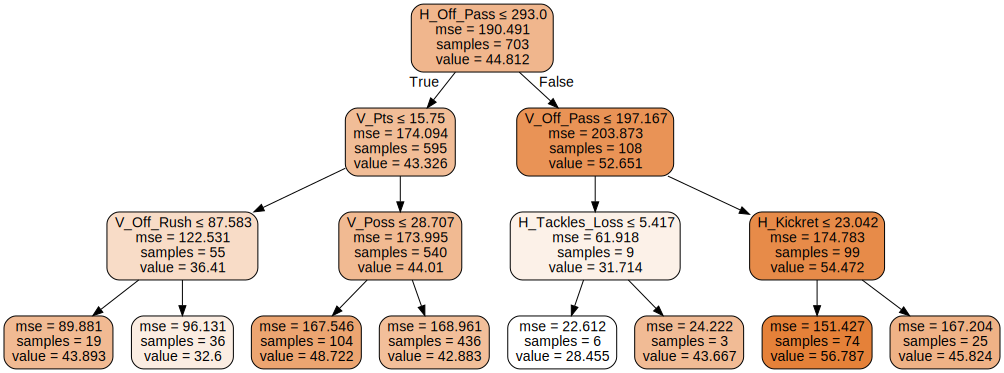

In [248]:
# No Over/Under -- Random Forest
from sklearn import ensemble
import graphviz
X = dfgame.drop(['Tot_Pts','Over/Under','Home_Team','Vis_Team','H_Game','V_Game'],axis=1)
y = dfgame['Tot_Pts'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1-train_ratio, random_state=77)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, 
                                                test_size = test_ratio/(test_ratio + validation_ratio),
                                                random_state=77)
frst_model=ensemble.RandomForestRegressor(random_state=77,n_estimators=500,max_depth=3)
frst_model.fit(X_train,y_train)
y_pred = frst_model.predict(X_test)
estimator = frst_model.estimators_[20]
dot_data=tree.export_graphviz(estimator, filled=True, rounded=True,
                                     special_characters=True,feature_names=X_train.columns)
graphviz.Source(dot_data)

In [249]:
# get importance
importance = frst_model.feature_importances_
# summarize feature importance
coef = pd.DataFrame(importance, X_train.columns, columns=['Importance'])
ind=np.flip(np.argsort(importance))
coef_sort = coef.iloc[ind]
print(coef_sort)

                Importance
H_Off_Pass        0.297633
V_Off_Pass        0.139007
V_Pts             0.060716
H_Off_Rush        0.055128
V_Def_RZ_Pct      0.048678
H_Pts             0.042155
H_Pass_Metric     0.035994
V_Def_Pass        0.031543
Temperature       0.026151
V_RZ_Pct          0.024155
Wind              0.023822
H_Def_RZ_Pct      0.018751
V_Def_Rush        0.013130
V_Pts_Opp         0.013073
V_Kickret         0.012328
H_Kickret         0.011993
H_Def_Rush        0.010669
V_TO_Gain         0.009746
V_Pass_Metric     0.008337
V_Tackles_Loss    0.007540
V_Rush_Metric     0.007514
V_Yds_Pen         0.006625
H_Sacks_Def       0.006165
Humidity          0.006154
H_Puntret         0.006063
H_TO_Gain         0.005986
V_Off_Rush        0.005754
H_Yds_Pen         0.005508
H_Pts_Opp         0.005360
H_Rush_Metric     0.005239
H_FG_Pct          0.005202
V_Poss            0.004755
V_FG_Pct          0.004312
H_Poss            0.003761
V_Plays           0.003621
H_TO_Lost         0.003540
V

In [250]:
metric=mean_squared_error(y_test,y_pred,squared=False)
ou = dfgame.loc[X_test.index,'Over/Under']
results = pd.DataFrame(y_test,columns=['Actual'],index=X_test.index)
results['Predicted'] = y_pred
results['Over/Under'] = ou
corr = (((results['Actual']<results['Over/Under']) & (results['Predicted']<results['Over/Under'])).sum() +
        ((results['Actual']>results['Over/Under']) & (results['Predicted']>results['Over/Under'])).sum())
tot = (results['Actual']<results['Over/Under']).sum() + (results['Actual']>results['Over/Under']).sum()
acc = corr/tot
print(f'RMSE = {metric:.3f}, Accuracy = {acc:.3f}')

RMSE = 13.892, Accuracy = 0.519


In [253]:
short = list(coef_sort[coef_sort['Importance']>0.01].index)
X = dfgame[short]
y = dfgame['Tot_Pts'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1-train_ratio, random_state=77)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, 
                                                test_size = test_ratio/(test_ratio + validation_ratio),
                                                random_state=77)
short_frst=ensemble.RandomForestRegressor(random_state=77,n_estimators=500,max_depth=3)
short_frst.fit(X_train,y_train)
y_pred = short_frst.predict(X_test)
metric=mean_squared_error(y_test,y_pred,squared=False)
ou = dfgame.loc[X_test.index,'Over/Under']
results = pd.DataFrame(y_test,columns=['Actual'],index=X_test.index)
results['Predicted'] = y_pred
results['Over/Under'] = ou
corr = (((results['Actual']<results['Over/Under']) & (results['Predicted']<results['Over/Under'])).sum() +
        ((results['Actual']>results['Over/Under']) & (results['Predicted']>results['Over/Under'])).sum())
tot = (results['Actual']<results['Over/Under']).sum() + (results['Actual']>results['Over/Under']).sum()
acc = corr/tot
print(f'RMSE = {metric:.3f}, Accuracy = {acc:.3f}')

RMSE = 13.932, Accuracy = 0.519


In [254]:
# get importance
importance = short_frst.feature_importances_
# summarize feature importance
coef = pd.DataFrame(importance, X_train.columns, columns=['Importance'])
ind=np.flip(np.argsort(importance))
coef_sort = coef.iloc[ind]
print(coef_sort)

               Importance
H_Off_Pass       0.306792
V_Off_Pass       0.155072
V_Pts            0.068467
H_Off_Rush       0.068182
V_Def_RZ_Pct     0.056636
H_Pts            0.049509
H_Pass_Metric    0.045649
V_Def_Pass       0.038769
Temperature      0.035080
Wind             0.030156
V_RZ_Pct         0.029607
H_Def_RZ_Pct     0.025104
H_Def_Rush       0.020466
V_Def_Rush       0.019375
V_Kickret        0.018796
V_Pts_Opp        0.016237
H_Kickret        0.016105


In [257]:
X = dfgame[short]
y = dfgame['Tot_Pts'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1-train_ratio, random_state=77)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, 
                                                test_size = test_ratio/(test_ratio + validation_ratio),
                                                random_state=77)
sca_train = robust.fit_transform(X_train)
sca_test = robust.transform(X_test)
LR.fit(sca_train,y_train)
y_pred=LR.predict(sca_test)
metric=mean_squared_error(y_test,y_pred,squared=False)
ou = dfgame.loc[X_test.index,'Over/Under']
results = pd.DataFrame(y_test,columns=['Actual'],index=X_test.index)
results['Predicted'] = y_pred
results['Over/Under'] = ou
corr = (((results['Actual']<results['Over/Under']) & (results['Predicted']<results['Over/Under'])).sum() +
        ((results['Actual']>results['Over/Under']) & (results['Predicted']>results['Over/Under'])).sum())
tot = (results['Actual']<results['Over/Under']).sum() + (results['Actual']>results['Over/Under']).sum()
acc = corr/tot
print(f'RMSE = {metric:.3f}, Accuracy = {acc:.3f}')
coef = pd.DataFrame(LR.coef_, X_train.columns, columns=['LR Coefficient'])
ind=np.flip(np.argsort(abs(LR.coef_)))
print(coef.iloc[ind])

RMSE = 13.525, Accuracy = 0.523
               LR Coefficient
H_Off_Pass           3.428772
Wind                -2.058293
V_Off_Pass           2.057944
V_Def_Rush           1.948246
H_Pts                1.588526
H_Def_Rush           1.345372
H_Off_Rush           1.273484
V_Def_RZ_Pct         1.179336
H_Pass_Metric       -1.041629
V_Pts                1.034355
V_Def_Pass           1.004261
V_Kickret            0.839534
V_Pts_Opp           -0.789951
V_RZ_Pct             0.512408
Temperature          0.319870
H_Kickret            0.073937
H_Def_RZ_Pct        -0.059306


In [245]:
# Over/Under -- Random Forest
from sklearn import ensemble
import graphviz
X = dfgame.drop(['Tot_Pts','Home_Team','Vis_Team','H_Game','V_Game'],axis=1)
y = dfgame['Tot_Pts'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1-train_ratio, random_state=77)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, 
                                                test_size = test_ratio/(test_ratio + validation_ratio),
                                                random_state=77)
frst_model=ensemble.RandomForestRegressor(random_state=77,n_estimators=500,max_depth=3)
frst_model.fit(X_train,y_train)
y_pred = frst_model.predict(X_test)
# get importance
importance = frst_model.feature_importances_
# summarize feature importance
coef = pd.DataFrame(importance, X_train.columns, columns=['Importance'])
ind=np.flip(np.argsort(importance))
coef_sort = coef.iloc[ind]
print(coef_sort)

                Importance
Over/Under        0.539605
H_Off_Pass        0.068717
V_RZ_Pct          0.029786
V_Off_Pass        0.025405
H_Def_Rush        0.022300
V_Pts             0.018939
H_Pts             0.017473
H_Off_Rush        0.016051
H_Def_RZ_Pct      0.016049
V_Def_Pass        0.015580
V_Def_RZ_Pct      0.014164
V_Rush_Metric     0.013275
V_Kickret         0.013046
H_Pass_Metric     0.012145
V_Def_Rush        0.011954
H_Yds_Pen         0.010810
H_Kickret         0.010291
H_Sacks_Def       0.009082
V_Tackles_Loss    0.008877
V_Yds_Pen         0.008855
H_FG_Pct          0.007963
V_Poss            0.007896
Temperature       0.007336
V_Sacks_Def       0.007097
H_Def_Pass        0.006997
H_Puntret         0.006265
H_RZ_Pct          0.006204
Wind              0.005892
V_Pts_Opp         0.005668
H_Plays           0.005453
H_Rush_Metric     0.004707
V_Plays           0.004491
V_Off_Rush        0.004436
H_Pts_Opp         0.003993
Humidity          0.003953
H_TO_Lost         0.003524
H

In [246]:
metric=mean_squared_error(y_test,y_pred,squared=False)
ou = dfgame.loc[X_test.index,'Over/Under']
results = pd.DataFrame(y_test,columns=['Actual'],index=X_test.index)
results['Predicted'] = y_pred
results['Over/Under'] = ou
corr = (((results['Actual']<results['Over/Under']) & (results['Predicted']<results['Over/Under'])).sum() +
        ((results['Actual']>results['Over/Under']) & (results['Predicted']>results['Over/Under'])).sum())
tot = (results['Actual']<results['Over/Under']).sum() + (results['Actual']>results['Over/Under']).sum()
acc = corr/tot
print(f'RMSE = {metric:.3f}, Accuracy = {acc:.3f}')

RMSE = 13.436, Accuracy = 0.511


In [720]:
by_home = pd.DataFrame(index=teams.keys())
grouped_by_home = extest.groupby(extest['Home_Team'])
for key, item in grouped_by_home:
    by_home.loc[key,'Avg_Total_Points'] = item.Tot_Pts.mean()
    by_home.loc[key,'Std_Total_Points'] = item.Tot_Pts.std()
    by_home.loc[key,'Avg_Passing_Yds'] = item.H_Off_Pass.mean()
    by_home.loc[key,'Avg_Rushing_Yds'] = item.H_Off_Rush.mean()
    by_home.loc[key,'Avg_Passing_Def'] = item.H_Def_Pass.mean()
    by_home.loc[key,'Avg_Rushing_Def'] = item.H_Def_Rush.mean()
by_home['Avg_Total_Yds'] = by_home['Avg_Passing_Yds'] + by_home['Avg_Rushing_Yds']
by_home['Avg_Total_Def'] = by_home['Avg_Passing_Def'] + by_home['Avg_Rushing_Def']
by_home['Passing_Rank'] = by_home['Avg_Passing_Yds'].rank(ascending=False)
by_home['Rushing_Rank'] = by_home['Avg_Rushing_Yds'].rank(ascending=False)
by_home['Offense_Rank'] = by_home['Avg_Total_Yds'].rank(ascending=False)
by_home['Passing_Def_Rank'] = by_home['Avg_Passing_Def'].rank(ascending=False)
by_home['Rushing_Def_Rank'] = by_home['Avg_Rushing_Def'].rank(ascending=False)
by_home['Defense_Rank'] = by_home['Avg_Total_Def'].rank(ascending=False)
by_home = by_home.drop(['Avg_Passing_Yds','Avg_Rushing_Yds','Avg_Total_Yds',
                        'Avg_Passing_Def','Avg_Rushing_Def','Avg_Total_Def'],axis=1)

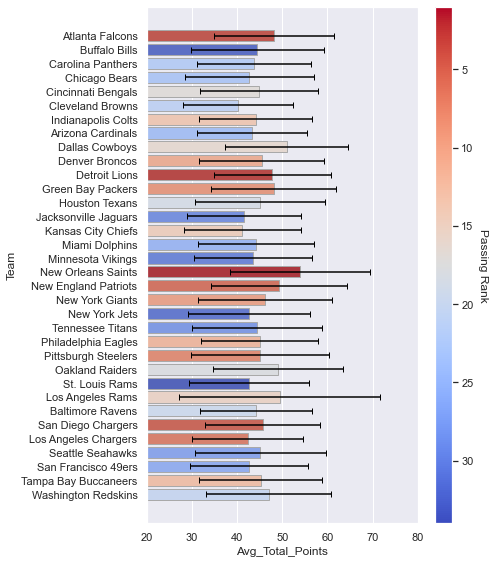

In [802]:
from matplotlib.cm import ScalarMappable

fig = plt.figure(figsize=(7,8))
ax = fig.add_subplot(1,1,1)
_ = plt.xlabel('Average Total Points')
_ = plt.ylabel('Team')
_ = plt.xlim(20,80)
category = list(by_home.index)
sns.set(font_scale=1.0)
sns.barplot(x=by_home['Avg_Total_Points'],y=category,edgecolor='darkgray',
            palette=colors_from_values(by_home['Passing_Rank'],'coolwarm_r'))
plt.errorbar(by_home['Avg_Total_Points'],category,xerr=by_home['Std_Total_Points'],color='black',linestyle='None',capsize=3)
sm = ScalarMappable(cmap='coolwarm_r', norm=plt.Normalize(34,1))
sm.set_array([])
cbar = plt.colorbar(sm,label='Passing Rank',aspect=30)
cbar.ax.invert_yaxis()
cbar.set_label('Passing Rank',rotation=270,labelpad=15)
fig.tight_layout()
fig.show()
fig.savefig('plots/fig99.png')


In [789]:
by_home['Passing_Rank'].corr(by_home['Avg_Total_Points'])

-0.5210525886928965

In [790]:
by_home['Rushing_Rank'].corr(by_home['Avg_Total_Points'])

-0.006615500915268446

In [791]:
by_home['Total_Rank'].corr(by_home['Avg_Total_Points'])

-0.48376556276867017

In [794]:
by_home['Passing_Def_Rank'].corr(by_home['Avg_Total_Points'])

-0.4347977271282208

In [795]:
by_home['Rushing_Def_Rank'].corr(by_home['Avg_Total_Points'])

-0.003995185113021996

In [798]:
by_home['Defense_Rank'].corr(by_home['Avg_Total_Points'])

-0.3469432262707415

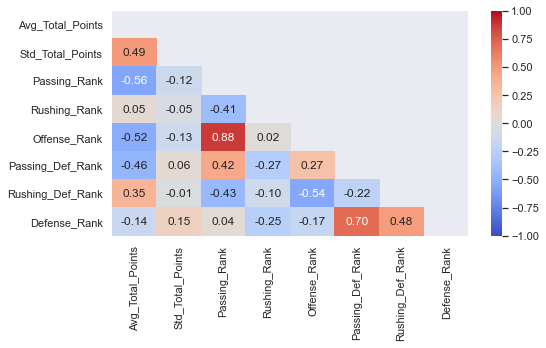

In [804]:
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(1,1,1)

mask = np.triu(by_home.corr())
sns.heatmap(by_home.corr(),vmin=-1.0,center=0,vmax=1.0,mask=mask,
            cmap='coolwarm',annot=True,fmt='.2f')
fig.tight_layout()
fig.show()
fig.savefig('plots/fig98.png')

In [549]:
by_week = extest[['Tot_Pts','Temperature']]
for ind in by_week.index: 
    by_week.loc[ind,'Week_Beg'] = weekofgame(ind)
    by_week.loc[ind,'Year'] = get_year(ind)
grouped_by_year = by_week.groupby(by_week['Year'])
for key, item in grouped_by_year:
    mapping = get_mapping(item,1)
    for code in item.index:
        by_week.loc[code,'Week'] = int(mapping[by_week.loc[code,'Week_Beg']])
by_week['Week'] = by_week['Week'].astype('int')

In [552]:
avg_pts_week = by_week['Tot_Pts'].groupby(by_week['Week']).mean()
avg_temp_week = by_week['Temperature'].groupby(by_week['Week']).mean()

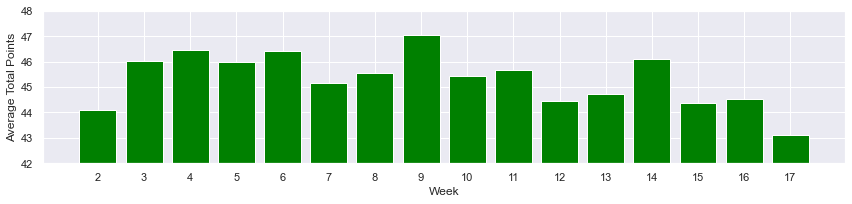

In [557]:
fig9 = plt.figure(figsize=(12,3))
_ = fig9.add_subplot(1,1,1)
_ = plt.xlabel('Week')
_ = plt.ylabel('Average Total Points')
_ = plt.ylim(42,48)
_ = plt.bar(avg_pts_week.index,avg_pts_week.values,color='green',
       tick_label=[str(i) for i in range(2,18)])
#ax2 = ax.twinx()
#ax2.set_ylabel('Temperature (°F)')
#ax2.set_ylim(50,70)
#ax2.plot(avg_temp_week.index,avg_temp_week.values,linewidth=1, color='blue')
#_ = fig9.add_subplot(1,1,1)
#_ = plt.bar()
fig9.tight_layout()  
fig9.show()

In [370]:
domed = extest[extest['dome'] == 1]
notdomed = extest[extest['dome'] == 0]

In [371]:
extest['Tot_Pts'].corr(extest['dome'])

0.06370235481393194

In [822]:
temp = notdomed[['Tot_Pts','Temperature']]
#bins = [i for i in range(0,91,10)]
#bins.remove(10)
bins = [-10,30,40,50,60,70,80,100]
grouped = temp.groupby(pd.cut(temp.Temperature,bins))
ind = np.arange(len(grouped['Tot_Pts'].mean()))
print(grouped['Tot_Pts'].mean(),grouped['Tot_Pts'].count())
type(grouped['Tot_Pts'].mean())

Temperature
(-10, 30]    43.725000
(30, 40]     44.138889
(40, 50]     44.528302
(50, 60]     44.914706
(60, 70]     45.847887
(70, 80]     44.831373
(80, 100]    43.824324
Name: Tot_Pts, dtype: float64 Temperature
(-10, 30]    160
(30, 40]     180
(40, 50]     159
(50, 60]     340
(60, 70]     355
(70, 80]     255
(80, 100]    148
Name: Tot_Pts, dtype: int64


pandas.core.series.Series

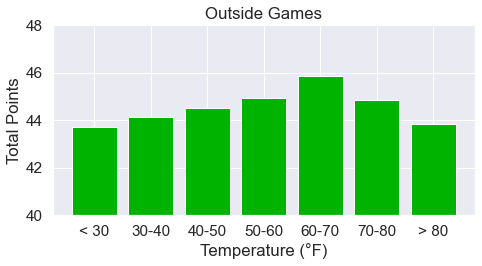

In [829]:
fig97 = plt.figure(figsize=(7,4))
ind = np.arange(len(grouped['Tot_Pts'].mean()))
counts = grouped['Tot_Pts'].count().values
# alp = counts/max(counts)
# colors = [(0,0.7,0,alp[a]) for a in range(len(alp))]
colors = (0,0.7,0)
_ = plt.bar(ind,grouped['Tot_Pts'].mean().values,color=colors)
_ = plt.xticks(ind,labels=('< 30','30-40','40-50','50-60','60-70','70-80','> 80'))
_ = plt.ylim(40,48)
_ = plt.xlabel('Temperature (°F)')
_ = plt.ylabel('Total Points')
_ = plt.title('Outside Games')
fig97.tight_layout()
plt.show()
fig97.savefig('plots/fig97.png')

24%


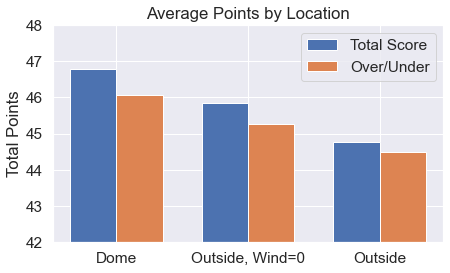

In [831]:
tpmean = (domed['Tot_Pts'].mean(),notdomed[notdomed['Wind']==0]['Tot_Pts'].mean(),notdomed['Tot_Pts'].mean())
oumean = (domed['Over/Under'].mean(),notdomed[notdomed['Wind']==0]['Over/Under'].mean(),
          notdomed['Over/Under'].mean())

fig96 = plt.figure(figsize=(7,4))
ax = fig.add_subplot(1,1,1)

ind = np.arange(3)  # the x locations for the groups
width = 0.35  # the width of the bars

sns.set(font_scale=1.4)
_ = plt.bar(ind - width/2, tpmean, width, label='Total Score')
_ = plt.bar(ind + width/2, oumean, width, label='Over/Under')

# Add some text for labels, title and custom x-axis tick labels, etc.
_ = plt.ylabel('Total Points')
_ = plt.title('Average Points by Location')
_ = plt.xticks(ind,labels=('Dome','Outside, Wind=0','Outside'))
_ = plt.legend(loc='upper right')
_ = plt.ylim(42,48)
fig.show()
pct=round(len(X_show[(X_show['dome']==0)&(X_show['Wind'] < 5)])/len(X_show[(X_show['dome']==0)])*100)
print(f'{pct:2d}%')
fig96.savefig('plots/fig96.png')

23%


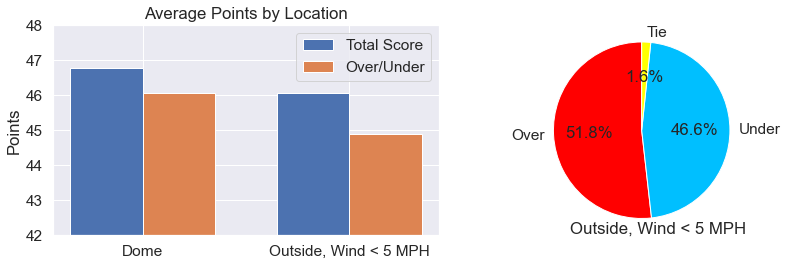

In [834]:
tpmean = (extest[extest['dome']==1]['Tot_Pts'].mean(),extest[(extest['dome']==0)&(extest['Wind'] < 5)]['Tot_Pts'].mean())
oumean = (extest[extest['dome']==1]['Over/Under'].mean(),extest[(extest['dome']==0)&(extest['Wind'] < 5)]['Over/Under'].mean())

o_u = np.array([(notdomed[notdomed['Wind']<5]['Tot_Pts'] > notdomed[notdomed['Wind']<5]['Over/Under']).sum(),
                (notdomed[notdomed['Wind']<5]['Tot_Pts'] < notdomed[notdomed['Wind']<5]['Over/Under']).sum(),
                 (notdomed[notdomed['Wind']<5]['Tot_Pts']==notdomed[notdomed['Wind']<5]['Over/Under']).sum()])
labels = 'Over','Under','Tie'
colors = ('red','deepskyblue','yellow')

fig95 = plt.figure(figsize=(12,4))
_ = fig95.add_subplot(1,2,1)

ind = np.arange(2)  # the x locations for the groups
width = 0.35  # the width of the bars

#sns.set(font_scale=1.0)
_ = plt.bar(ind - width/2, tpmean, width, label='Total Score')
_ = plt.bar(ind + width/2, oumean, width, label='Over/Under')

# Add some text for labels, title and custom x-axis tick labels, etc.
_ = plt.ylabel('Points')
_ = plt.title('Average Points by Location')
_ = plt.xticks(ind,labels=('Dome','Outside, Wind < 5 MPH'))
_ = plt.legend(loc='upper right')
_ = plt.ylim(42,48)

ax2 = fig95.add_subplot(1,2,2)
_ = plt.pie(o_u/sum(o_u),labels=labels,autopct='%1.1f%%',radius=1.05,colors=colors,
        startangle=90)
ax2.text(0.16,0.01,'Outside, Wind < 5 MPH',transform=ax2.transAxes)
fig95.tight_layout()
fig95.show()
pct=round(len(extest[(extest['dome']==0)&(extest['Wind'] < 5)])/len(extest[(extest['dome']==0)])*100)
print(f'{pct:2d}%')
fig95.savefig('plots/fig95.png')

In [ ]:
wind=notdomed[notdomed['Wind']<5]
out_diff=extest[extest['matrixturf']==1]['Tot_Pts']
no_matrix=extest[extest['matrixturf']==0]['Tot_Pts']
t_result,p_result=stats.ttest_ind(matrix,no_matrix,equal_var=False)
print(f't = {t_result}, p = {p_result}')

In [464]:
len(extest[(extest['dome']==0)&(extest['Wind'] < 5)])

365

In [454]:
(domed['Tot_Pts'] > domed['Over/Under']).mean()

0.5026548672566372

In [398]:
print(tpmean[1])

47.24175824175824


32%


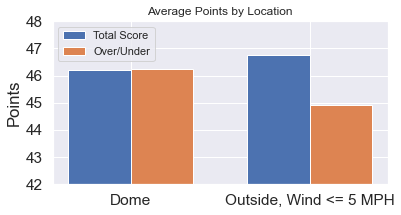

In [429]:
tpmean = (X_show[X_show['dome']==1]['Tot_Pts'].mean(),X_show[(X_show['dome']==0)&(X_show['Wind'] <= 5)]['Tot_Pts'].mean())
oumean = (X_show[X_show['dome']==1]['Over/Under'].mean(),X_show[(X_show['dome']==0)&(X_show['Wind'] < 5)]['Over/Under'].mean())

fig95 = plt.figure(figsize=(6,3))
ax = fig95.add_subplot(1,1,1)

ind = np.arange(2)  # the x locations for the groups
width = 0.35  # the width of the bars

sns.set(font_scale=1.0)
_ = plt.bar(ind - width/2, tpmean, width, label='Total Score')
_ = plt.bar(ind + width/2, oumean, width, label='Over/Under')

# Add some text for labels, title and custom x-axis tick labels, etc.
_ = plt.ylabel('Points')
_ = plt.title('Average Points by Location')
_ = plt.xticks(ind,labels=('Dome','Outside, Wind <= 5 MPH'))
_ = plt.legend(loc='upper left')
_ = plt.ylim(42,48)
fig95.show()
pct=round(len(X_show[(X_show['dome']==0)&(X_show['Wind'] <= 5)])/len(X_show[(X_show['dome']==0)])*100)
print(f'{pct:2d}%')
#fig95.savefig('plots/fig96.png')

In [691]:
outside_means=bootstrap(extest['Tot_Pts']>extest['Over/Under'],365,np.mean)

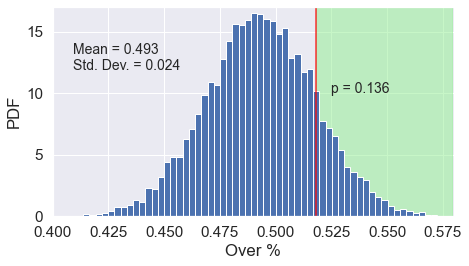

In [842]:
mu = np.mean(outside_means)
sd = np.std(outside_means)
pct2_5 = np.percentile(outside_means,2.5)
pct97_5 = np.percentile(outside_means,97.5)
x = np.arange(0.518,0.58,0.001)
ymax = 17.0
y1 = ymax
y2 = 0.0
fig78 = plt.figure(figsize=(7,4))
ax = fig78.add_subplot(1,1,1)
_ = plt.hist(outside_means,bins=57,density=True,label='Seasonal mean Over%',zorder=1)
_ = plt.ylim(0,ymax)
_ = plt.xlim(0.40,0.58)
ax.text(0.05,0.7,'Mean = {0:.3f}\nStd. Dev. = {1:.3f}'.format(mu,sd),transform=ax.transAxes,fontsize='small')
p = 1.0-stats.percentileofscore(outside_means,0.518)/100
ax.text(0.525,10,'p = {:.3f}'.format(p),fontsize='small')
#ax.text(0.05,0.2,'95% Conf. Int. =\n [{0:.3f},{1:.3f}]'.format(pct2_5,pct97_5),
#                                                               transform=ax.transAxes,fontsize='small')
ax.fill_between(x, y1, y2,color='lightgreen',alpha=0.5)
#_ = plt.vlines(pct2_5,0,ymax,color='red',alpha=0.8)
_ = plt.vlines(0.518,0,ymax,color='red',alpha=0.8)
#_ = plt.scatter(outside_count.values[0],0.4,marker='.',color='red',s=200,zorder=2)
_ = plt.xlabel('Over %')
_ = plt.ylabel('PDF')
fig78.tight_layout()
plt.show()
fig78.savefig('plots/fig78.png')

In [705]:
notdomed['Tot_Pts'].corr(notdomed['Temperature'])

0.04175134613588856

In [714]:
notdomed['Tot_Pts'].corr(notdomed['Temperature']**(0.5))

0.056523605587800195

In [703]:
test = notdomed[notdomed['Temperature']<65]
test['Tot_Pts'].corr(test['Temperature'])

0.06161124098270196

In [702]:
test = notdomed[notdomed['Temperature']>=65]
test['Tot_Pts'].corr(test['Temperature'])

-0.10142750464523927

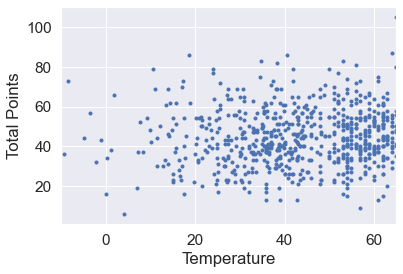

In [694]:
_ = plt.plot(notdomed['Temperature'],notdomed['Tot_Pts'],marker='.',linestyle="None")
_ = plt.xlim(-10,65)
_ = plt.xlabel('Temperature')
_ = plt.ylabel('Total Points')
plt.show()

In [382]:
X_show['Wind'].describe()

count    1098.000000
mean        6.310565
std         6.297769
min         0.000000
25%         0.000000
50%         6.000000
75%        10.000000
max        71.000000
Name: Wind, dtype: float64

In [664]:
X_show[X_show['Wind']==71]

,Home_Team,Vis_Team,H_Game,V_Game,Tot_Pts,Over/Under,H_Pts,H_Pts_Opp,V_Pts,V_Pts_Opp,...,Temperature,Wind,a_turf,astroplay,astroturf,fieldturf,grass,matrixturf,sportturf,Week
Code,,,,,,,,,,,,,,,,,,,,,
201612040pit,Pittsburgh Steelers,New York Giants,24.0,14.0,38,49.5,21.166667,21.5,23.666667,17.5,...,28.113559,71.0,0,0,0,0,1,0,0,13


In [262]:
surf_cols=['a_turf','astroplay','fieldturf','grass','matrixturf','sportturf']
X_show['astroturf'] = 1-X_show[surf_cols].sum(axis=1)
surf_cols.append('astroturf')
surface = pd.concat([X_show[['Tot_Pts']],X_show[surf_cols]],axis=1)
by_surface = combine_dummies(surface,'surface',surf_cols)
avg_pts_surf=by_surface['Tot_Pts'].groupby(by_surface['surface']).mean()

In [263]:
count_surf = by_surface['Tot_Pts'].groupby(by_surface['surface']).count()
count_surf

surface
a_turf         31
astroplay      25
astroturf      18
fieldturf     293
grass         619
matrixturf     31
sportturf      81
Name: Tot_Pts, dtype: int64

In [724]:
by_team = pd.DataFrame(index=teams.keys())
grouped_by_home = extest.groupby(extest['Home_Team'])
grouped_by_vis = extest.groupby(extest['Vis_Team'])
for key, item in grouped_by_home:
    by_team.loc[key,'Avg Home Team Score'] = round(item['H_Game'].mean(),3)
    by_team.loc[key,'Avg Home Total Score'] = round(item['Tot_Pts'].mean(),3)
for key,item in grouped_by_vis:
    by_team.loc[key,'Avg Vis Team Score'] = round(item['V_Game'].mean(),3)
    by_team.loc[key,'Avg Vis Total Score'] = round(item['Tot_Pts'].mean(),3)
by_team['Team Home - Vis'] = by_team['Avg Home Team Score'] - by_team['Avg Vis Team Score']
by_team['Total Home - Vis'] = by_team['Avg Home Total Score'] - by_team['Avg Vis Total Score']
by_team = by_team[['Avg Home Team Score','Avg Vis Team Score','Team Home - Vis',
                   'Avg Home Total Score','Avg Vis Total Score','Total Home - Vis']]
by_team

,Avg Home Team Score,Avg Vis Team Score,Team Home - Vis,Avg Home Total Score,Avg Vis Total Score,Total Home - Vis
Atlanta Falcons,26.174,25.232,0.942,48.116,49.087,-0.971
Buffalo Bills,22.465,19.062,3.403,44.493,43.200,1.293
Carolina Panthers,22.103,22.968,-0.865,43.706,48.556,-4.850
Chicago Bears,21.873,20.971,0.902,42.730,44.588,-1.858
Cincinnati Bengals,23.288,20.574,2.714,44.822,42.623,2.199
Cleveland Browns,17.940,17.972,-0.032,40.209,43.056,-2.847
Indianapolis Colts,23.290,23.902,-0.612,44.087,50.246,-6.159
Arizona Cardinals,22.254,19.015,3.239,43.343,42.284,1.059
Dallas Cowboys,26.609,22.000,4.609,50.938,44.057,6.881
Denver Broncos,25.359,22.137,3.222,45.422,45.589,-0.167


In [751]:
nor_home = extest[extest['Home_Team']=='New Orleans Saints']
nor_away = extest[extest['Vis_Team']=='New Orleans Saints']
nor_mean_diff = permuted(nor_home['H_Game'],nor_away['V_Game'],diff_of_means)

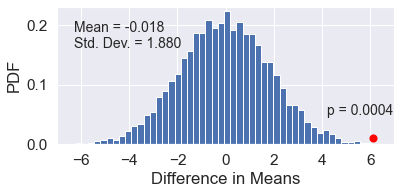

In [846]:
p = 1.0 - stats.percentileofscore(nor_mean_diff,6.112)/100

mu = np.mean(nor_mean_diff)
sd = np.std(nor_mean_diff)
#x = np.arange(pct2_5,pct97_5,0.001)
ymax = 0.23
y1 = ymax
y2 = 0.0
fig79 = plt.figure(figsize=(6,3))
ax = fig79.add_subplot(1,1,1)
_ = plt.hist(nor_mean_diff,bins=55,density=True,label='Seasonal mean Over%',zorder=1)
_ = plt.ylim(0,ymax)
_ = plt.xlim(-7,7)
ax.text(0.05,0.7,'Mean = {0:.3f}\nStd. Dev. = {1:.3f}'.format(mu,sd),transform=ax.transAxes,fontsize='small')
ax.text(4.2,0.05,'p = {:.4f}'.format(p),fontsize='small')
_ = plt.xlabel('Difference in Means')
_ = plt.ylabel('PDF')
#ax.text(0.05,0.2,'95% Conf. Int. =\n [{0:.3f},{1:.3f}]'.format(pct2_5,pct97_5),
#                                                               transform=ax.transAxes,fontsize='small')
#ax.fill_between(x, y1, y2,color='lightgreen',alpha=0.5)
#_ = plt.vlines(pct2_5,0,ymax,color='red',alpha=0.8)
#_ = plt.vlines(pct97_5,0,ymax,color='red',alpha=0.8)
_ = plt.scatter(6.112,0.01,marker='.',color='red',s=200,zorder=2)
#ax. text(0.58,1.2,'2010 Over%',fontsize='small')
fig79.tight_layout()
plt.show()
fig79.savefig('plots/fig79.png')

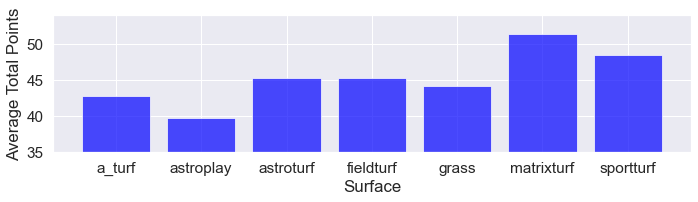

In [847]:
fig10 = plt.figure(figsize=(10,3))
ax = fig10.add_subplot(1,1,1)
ax.set_xlabel('Surface')
ax.set_ylabel('Average Total Points')
ax.set_ylim(35,54)
ax.bar(avg_pts_surf.index,avg_pts_surf.values,color='blue',alpha=0.7)
fig10.show()
fig10.tight_layout()
fig10.savefig('plots/fig10.png')

In [340]:
avg_pts_surf.values

array([42.77419355, 39.8       , 45.22222222, 45.31740614, 44.19709208,
       51.41935484, 48.43209877])

In [761]:
matrix=extest[extest['matrixturf']==1]['Tot_Pts']
no_matrix=extest[extest['matrixturf']==0]['Tot_Pts']
t_result,p_result=stats.ttest_ind(matrix,no_matrix,equal_var=False)
print(f't = {t_result}, p = {p_result}')

t = 3.20715277387888, p = 0.002148267792649663


In [260]:
X_show[X_show['matrixturf']==1]

,Home_Team,Vis_Team,H_Game,V_Game,Over/Under,Tot_Pts,H_Pts,H_Pts_Opp,V_Pts,V_Pts_Opp,...,Wind,Humidity,a_turf,astroplay,fieldturf,grass,matrixturf,sportturf,Week,dome
Code,,,,,,,,,,,,,,,,,,,,,
201611240dal,Dallas Cowboys,Washington Redskins,31.0,26.0,53.0,57.0,30.666667,18.333333,25.833333,20.166667,...,0.0,0,0,0,0,0,1,0,12,1
201012190dal,Dallas Cowboys,Washington Redskins,33.0,30.0,44.5,63.0,27.833333,29.833333,18.000000,29.500000,...,0.0,0,0,0,0,0,1,0,15,1
201612180dal,Dallas Cowboys,Tampa Bay Buccaneers,26.0,20.0,47.5,46.0,25.333333,18.000000,23.500000,17.833333,...,0.0,0,0,0,0,0,1,0,15,1
201311280dal,Dallas Cowboys,Oakland Raiders,31.0,24.0,49.5,55.0,24.333333,23.833333,19.166667,26.833333,...,0.0,0,0,0,0,0,1,0,13,1
201610300dal,Dallas Cowboys,Philadelphia Eagles,29.0,23.0,44.0,52.0,26.500000,17.833333,26.000000,14.666667,...,0.0,0,0,0,0,0,1,0,8,1
201811220dal,Dallas Cowboys,Washington Redskins,31.0,23.0,40.0,54.0,22.666667,18.833333,19.000000,18.500000,...,0.0,0,0,0,0,0,1,0,12,1
201711230dal,Dallas Cowboys,Los Angeles Chargers,6.0,28.0,46.5,34.0,24.666667,24.166667,24.833333,17.166667,...,0.0,0,0,0,0,0,1,0,12,1
201210280dal,Dallas Cowboys,New York Giants,24.0,29.0,48.0,53.0,18.833333,22.166667,31.333333,18.833333,...,0.0,0,0,0,0,0,1,0,8,1
201410270dal,Dallas Cowboys,Washington Redskins,17.0,20.0,49.0,37.0,29.833333,19.833333,24.166667,27.666667,...,0.0,0,0,0,0,0,1,0,8,1


In [332]:
X_show[X_show['matrixturf']==1]['Tot_Pts'].mean(), X_show[X_show['matrixturf']==1]['Tot_Pts'].std()

(51.41935483870968, 11.884932179159701)

In [333]:
(X_show[(X_show['Home_Team'] == 'Dallas Cowboys') & (X_show['matrixturf'] == 0)]['Tot_Pts'].mean(),
 X_show[(X_show['Home_Team'] == 'Dallas Cowboys') & (X_show['matrixturf'] == 0)]['Tot_Pts'].std())

(50.75, 9.322910847297997)

In [334]:
X_show[X_show['astroplay']==1]['Tot_Pts'].mean(), X_show[X_show['astroplay']==1]['Tot_Pts'].std()

(39.8, 12.662279942148386)

In [335]:
X_show[X_show['astroplay']==1]

,Home_Team,Vis_Team,H_Game,V_Game,Over/Under,Tot_Pts,H_Pts,H_Pts_Opp,V_Pts,V_Pts_Opp,...,Wind,Humidity,a_turf,astroplay,fieldturf,grass,matrixturf,sportturf,Week,dome
Code,,,,,,,,,,,,,,,,,,,,,
201211180ram,St. Louis Rams,New York Jets,13.0,27.0,38.5,40.0,16.833333,22.000000,15.666667,25.500000,...,0.0,0,0,1,0,0,0,0,11,1
201012260buf,Buffalo Bills,New England Patriots,3.0,34.0,45.5,37.0,20.500000,20.000000,37.833333,19.166667,...,16.0,69,0,1,0,0,0,0,16,0
201312220ram,St. Louis Rams,Tampa Bay Buccaneers,23.0,13.0,43.0,36.0,25.166667,21.000000,22.333333,22.333333,...,0.0,0,0,1,0,0,0,0,16,1
201311240ram,St. Louis Rams,Chicago Bears,42.0,21.0,46.0,63.0,25.833333,18.833333,25.833333,25.500000,...,0.0,0,0,1,0,0,0,0,12,1
201012120buf,Buffalo Bills,Cleveland Browns,13.0,6.0,39.0,19.0,20.333333,22.500000,23.500000,19.000000,...,6.0,95,0,1,0,0,0,0,14,0
201110300ram,St. Louis Rams,New Orleans Saints,31.0,21.0,48.5,52.0,9.333333,28.500000,34.166667,19.333333,...,0.0,0,0,1,0,0,0,0,8,1
201412110ram,St. Louis Rams,Arizona Cardinals,6.0,12.0,40.5,18.0,24.833333,12.500000,18.500000,16.500000,...,0.0,0,0,1,0,0,0,0,15,1
201511150ram,St. Louis Rams,Chicago Bears,13.0,37.0,42.5,50.0,18.166667,15.166667,19.333333,23.666667,...,0.0,0,0,1,0,0,0,0,10,1
201511010ram,St. Louis Rams,San Francisco 49ers,27.0,6.0,39.5,33.0,18.000000,19.833333,13.833333,29.500000,...,0.0,0,0,1,0,0,0,0,8,1


In [336]:
X_show[(X_show['astroplay']==1) & (X_show['Home_Team'] == 'Buffalo Bills')]

,Home_Team,Vis_Team,H_Game,V_Game,Over/Under,Tot_Pts,H_Pts,H_Pts_Opp,V_Pts,V_Pts_Opp,...,Wind,Humidity,a_turf,astroplay,fieldturf,grass,matrixturf,sportturf,Week,dome
Code,,,,,,,,,,,,,,,,,,,,,
201012260buf,Buffalo Bills,New England Patriots,3.0,34.0,45.5,37.0,20.500000,20.000000,37.833333,19.166667,...,16.0,69,0,1,0,0,0,0,16,0
201012120buf,Buffalo Bills,Cleveland Browns,13.0,6.0,39.0,19.0,20.333333,22.500000,23.500000,19.000000,...,6.0,95,0,1,0,0,0,0,14,0
201011280buf,Buffalo Bills,Pittsburgh Steelers,16.0,19.0,44.0,35.0,25.333333,25.166667,24.833333,19.166667,...,13.0,78,0,1,0,0,0,0,12,0
201011140buf,Buffalo Bills,Detroit Lions,14.0,12.0,45.0,26.0,22.166667,30.666667,26.166667,22.333333,...,12.0,36,0,1,0,0,0,0,10,0
201011070buf,Buffalo Bills,Chicago Bears,19.0,22.0,41.5,41.0,20.166667,32.666667,17.833333,16.666667,...,0.0,0,0,1,0,0,0,0,9,1


In [343]:
X_show[(X_show['Home_Team'] == 'Los Angeles Rams')]

,Home_Team,Vis_Team,H_Game,V_Game,Over/Under,Tot_Pts,H_Pts,H_Pts_Opp,V_Pts,V_Pts_Opp,...,Wind,Humidity,a_turf,astroplay,fieldturf,grass,matrixturf,sportturf,Week,dome
Code,,,,,,,,,,,,,,,,,,,,,
201811110ram,Los Angeles Rams,Seattle Seahawks,36.0,31.0,51.0,67.0,32.833333,27.333333,24.500000,17.500000,...,1.0,0,0,0,0,1,0,0,10,0
201701010ram,Los Angeles Rams,Arizona Cardinals,6.0,44.0,39.0,50.0,13.166667,29.500000,28.666667,32.666667,...,0.0,0,0,0,0,1,0,0,17,0
201810280ram,Los Angeles Rams,Green Bay Packers,29.0,27.0,57.0,56.0,33.666667,19.166667,24.666667,24.000000,...,1.0,0,0,0,0,1,0,0,8,0
201612110ram,Los Angeles Rams,Atlanta Falcons,14.0,42.0,44.0,56.0,11.666667,20.833333,31.166667,27.500000,...,1.0,0,0,0,0,1,0,0,14,0
201710220ram,Los Angeles Rams,Arizona Cardinals,33.0,0.0,45.5,33.0,29.833333,23.000000,19.833333,26.333333,...,10.0,0,0,0,0,1,0,0,7,0
201912290ram,Los Angeles Rams,Arizona Cardinals,31.0,24.0,46.0,55.0,22.833333,24.833333,23.666667,26.666667,...,0.0,47,0,0,0,1,0,0,17,0
201712100ram,Los Angeles Rams,Philadelphia Eagles,35.0,43.0,47.5,78.0,30.333333,14.000000,32.666667,15.500000,...,0.0,0,0,0,0,1,0,0,14,0
201811190ram,Los Angeles Rams,Kansas City Chiefs,54.0,51.0,63.5,105.0,32.500000,27.333333,34.666667,20.833333,...,0.0,0,0,0,0,1,0,0,11,0
201911250ram,Los Angeles Rams,Baltimore Ravens,6.0,45.0,47.0,51.0,21.000000,15.666667,34.333333,16.000000,...,5.0,64,0,0,0,1,0,0,12,0


In [782]:
X_show[X_show['a_turf']==1]

,Home_Team,Vis_Team,H_Game,V_Game,Over/Under,Tot_Pts,H_Pts,H_Pts_Opp,V_Pts,V_Pts_Opp,...,Wind,Humidity,a_turf,astroplay,fieldturf,grass,matrixturf,sportturf,Week,dome
Code,,,,,,,,,,,,,,,,,,,,,
201512060buf,Buffalo Bills,Houston Texans,30.0,21.0,41.5,51.0,23.666667,25.333333,22.500000,16.500000,...,8.0,65,1,0,0,0,0,0,13,0
201612240buf,Buffalo Bills,Miami Dolphins,31.0,34.0,44.5,65.0,24.333333,23.666667,23.666667,22.000000,...,13.0,0,1,0,0,0,0,0,16,0
201112040buf,Buffalo Bills,Tennessee Titans,17.0,23.0,44.0,40.0,16.166667,26.833333,20.166667,19.666667,...,18.0,41,1,0,0,0,0,0,13,0
201112180buf,Buffalo Bills,Miami Dolphins,23.0,30.0,40.5,53.0,12.833333,32.333333,24.833333,13.333333,...,12.0,64,1,0,0,0,0,0,15,0
201112240buf,Buffalo Bills,Denver Broncos,40.0,14.0,43.5,54.0,14.833333,32.833333,20.166667,19.833333,...,2.0,42,1,0,0,0,0,0,16,0
201711120buf,Buffalo Bills,New Orleans Saints,10.0,47.0,48.5,57.0,25.000000,21.333333,30.333333,15.000000,...,2.0,0,1,0,0,0,0,0,10,0
201212300buf,Buffalo Bills,New York Jets,28.0,9.0,41.0,37.0,17.500000,23.500000,16.166667,19.833333,...,18.0,53,1,0,0,0,0,0,17,0
201810290buf,Buffalo Bills,New England Patriots,6.0,25.0,44.5,31.0,13.000000,21.333333,31.166667,26.500000,...,16.0,0,1,0,0,0,0,0,8,0
201811040buf,Buffalo Bills,Chicago Bears,9.0,41.0,38.0,50.0,10.666667,20.333333,28.500000,20.000000,...,12.0,0,1,0,0,0,0,0,9,0


In [339]:
X_show[X_show['sportturf']==1]['Home_Team'].unique()

array(['Minnesota Vikings', 'New Orleans Saints', 'Baltimore Ravens'],
      dtype=object)

In [775]:
cols = X_show.columns[51:57]

In [777]:
cols

Index(['a_turf', 'astroplay', 'fieldturf', 'grass', 'matrixturf', 'sportturf'], dtype='object')

In [781]:
X_show[X_show[cols].sum(axis=1)==0]

,Home_Team,Vis_Team,H_Game,V_Game,Over/Under,Tot_Pts,H_Pts,H_Pts_Opp,V_Pts,V_Pts_Opp,...,Wind,Humidity,a_turf,astroplay,fieldturf,grass,matrixturf,sportturf,Week,dome
Code,,,,,,,,,,,,,,,,,,,,,
201812020htx,Houston Texans,Cleveland Browns,29.0,13.0,47.5,42.0,26.333333,16.333333,23.166667,28.333333,...,0.0,0,0,0,0,0,0,0,13,1
201911030kan,Kansas City Chiefs,Minnesota Vikings,26.0,23.0,46.0,49.0,26.333333,24.166667,27.833333,16.500000,...,15.0,37,0,0,0,0,0,0,9,0
201911100nor,New Orleans Saints,Atlanta Falcons,9.0,26.0,51.5,35.0,26.000000,16.833333,21.500000,33.666667,...,0.0,0,0,0,0,0,0,0,10,1
201812300htx,Houston Texans,Jacksonville Jaguars,20.0,3.0,39.5,23.0,27.666667,21.500000,13.666667,16.166667,...,0.0,0,0,0,0,0,0,0,17,1
201910270kan,Kansas City Chiefs,Green Bay Packers,24.0,31.0,48.0,55.0,27.000000,20.666667,29.000000,22.666667,...,5.0,60,0,0,0,0,0,0,8,0
201912080nor,New Orleans Saints,San Francisco 49ers,46.0,48.0,45.0,94.0,28.333333,21.000000,32.166667,19.833333,...,0.0,0,0,0,0,0,0,0,14,1
201910270buf,Buffalo Bills,Philadelphia Eagles,13.0,31.0,39.5,44.0,20.166667,15.166667,23.166667,26.500000,...,23.0,87,0,0,0,0,0,0,8,0
201912160nor,New Orleans Saints,Indianapolis Colts,34.0,7.0,48.5,41.0,30.000000,24.833333,23.000000,24.000000,...,0.0,0,0,0,0,0,0,0,15,1
201912080buf,Buffalo Bills,Baltimore Ravens,17.0,24.0,44.0,41.0,22.666667,16.166667,37.000000,13.166667,...,18.0,48,0,0,0,0,0,0,14,0


In [768]:
X_show[X_show.iloc[:,51:56].sum()==0]

IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

In [311]:
len(X_show[X_show['Home_Team']=='Dallas Cowboys'])

35

In [31]:
from scipy.stats import pearsonr

In [212]:
np.corrcoef(by_week['Tot_Pts'],by_week['Week'])

array([[ 1.       , -0.0648166],
       [-0.0648166,  1.       ]])

In [213]:
np.corrcoef(by_week['Tot_Pts'],by_week['Temperature'])

array([[1.        , 0.04835216],
       [0.04835216, 1.        ]])

In [235]:
np.corrcoef(by_week['Temperature'],by_week['Week'])

array([[ 1.        , -0.28474545],
       [-0.28474545,  1.        ]])

In [1278]:
LR.intercept_

45.48882113821139

In [198]:
teamcols = list(teams.keys())
teamcols.remove('Arizona Cardinals')
teamcols.remove('Las Vegas Raiders')
for col in teamcols:
    print(col, round(X_show.Tot_Pts.corr(stad[col]),3))

Atlanta Falcons 0.001
Buffalo Bills -0.061
Carolina Panthers 0.004
Chicago Bears -0.03
Cincinnati Bengals 0.015
Cleveland Browns -0.071
Indianapolis Colts -0.009
Dallas Cowboys 0.084
Denver Broncos 0.004
Detroit Lions 0.01
Green Bay Packers 0.036
Houston Texans -0.037
Jacksonville Jaguars -0.024
Kansas City Chiefs -0.073
Miami Dolphins -0.022
Minnesota Vikings 0.004
New Orleans Saints 0.124
New England Patriots 0.065
New York Giants 0.002
New York Jets -0.021
Tennessee Titans 0.0
Philadelphia Eagles -0.005
Pittsburgh Steelers -0.026
Oakland Raiders 0.059
St. Louis Rams -0.03
Los Angeles Rams 0.08
Baltimore Ravens -0.015
San Diego Chargers 0.001
Los Angeles Chargers -0.027
Seattle Seahawks 0.006
San Francisco 49ers -0.041
Tampa Bay Buccaneers -0.0
Washington Redskins 0.018


In [200]:
for col in teamcols:
    print(col, round(X_show.H_Off_Pass.corr(stad[col]),3))

Atlanta Falcons 0.147
Buffalo Bills -0.138
Carolina Panthers -0.064
Chicago Bears -0.068
Cincinnati Bengals -0.029
Cleveland Browns -0.055
Indianapolis Colts 0.043
Dallas Cowboys 0.016
Denver Broncos 0.01
Detroit Lions 0.145
Green Bay Packers 0.078
Houston Texans -0.039
Jacksonville Jaguars -0.07
Kansas City Chiefs -0.058
Miami Dolphins -0.083
Minnesota Vikings -0.082
New Orleans Saints 0.274
New England Patriots 0.163
New York Giants 0.022
New York Jets -0.132
Tennessee Titans -0.091
Philadelphia Eagles 0.045
Pittsburgh Steelers 0.093
Oakland Raiders 0.007
St. Louis Rams -0.13
Los Angeles Rams 0.039
Baltimore Ravens -0.038
San Diego Chargers 0.131
Los Angeles Chargers 0.07
Seattle Seahawks -0.049
San Francisco 49ers -0.101
Tampa Bay Buccaneers 0.038
Washington Redskins -0.031


In [201]:
for col in teamcols:
    print(col, round(X_show.H_Pass_Metric.corr(stad[col]),3))

Atlanta Falcons 0.126
Buffalo Bills -0.072
Carolina Panthers -0.063
Chicago Bears -0.074
Cincinnati Bengals 0.005
Cleveland Browns -0.04
Indianapolis Colts 0.002
Dallas Cowboys -0.015
Denver Broncos 0.003
Detroit Lions 0.122
Green Bay Packers 0.033
Houston Texans -0.034
Jacksonville Jaguars -0.039
Kansas City Chiefs -0.071
Miami Dolphins -0.039
Minnesota Vikings -0.076
New Orleans Saints 0.176
New England Patriots 0.179
New York Giants -0.017
New York Jets -0.105
Tennessee Titans -0.063
Philadelphia Eagles 0.012
Pittsburgh Steelers 0.075
Oakland Raiders 0.006
St. Louis Rams -0.056
Los Angeles Rams 0.016
Baltimore Ravens -0.019
San Diego Chargers 0.107
Los Angeles Chargers 0.076
Seattle Seahawks -0.024
San Francisco 49ers -0.045
Tampa Bay Buccaneers -0.002
Washington Redskins -0.056


In [203]:
for col in teamcols:
    print(col, round(X_show.V_Pts.corr(stad[col]),3))

Atlanta Falcons 0.009
Buffalo Bills -0.029
Carolina Panthers 0.008
Chicago Bears 0.005
Cincinnati Bengals -0.001
Cleveland Browns -0.038
Indianapolis Colts 0.003
Dallas Cowboys 0.054
Denver Broncos 0.037
Detroit Lions -0.033
Green Bay Packers -0.05
Houston Texans -0.015
Jacksonville Jaguars 0.0
Kansas City Chiefs 0.024
Miami Dolphins -0.065
Minnesota Vikings 0.017
New Orleans Saints -0.004
New England Patriots -0.044
New York Giants 0.03
New York Jets -0.003
Tennessee Titans -0.014
Philadelphia Eagles 0.057
Pittsburgh Steelers -0.012
Oakland Raiders 0.028
St. Louis Rams -0.024
Los Angeles Rams 0.09
Baltimore Ravens 0.023
San Diego Chargers 0.034
Los Angeles Chargers -0.046
Seattle Seahawks 0.007
San Francisco 49ers -0.033
Tampa Bay Buccaneers -0.004
Washington Redskins 0.018


In [238]:
domed = X_show[X_show['dome']==1]
notdomed = X_show[X_show['dome']==0]

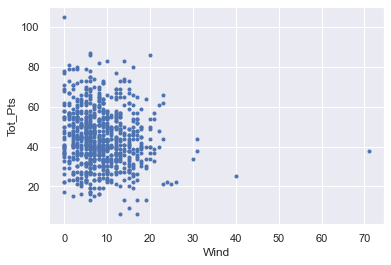

In [239]:
fig = plt.figure()
_ = fig.add_subplot(1,1,1)
_ = plt.xlabel('Wind')
_ = plt.ylabel('Tot_Pts')
#_ = plt.ylim(0.05,0.15)
_ = plt.plot(notdomed['Wind'],notdomed['Tot_Pts'],marker='.',linestyle='None')
fig.show()
#fig8.savefig('plots/fig8.png')

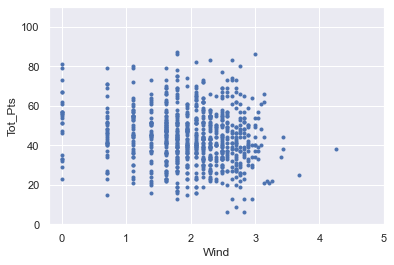

In [270]:
fig = plt.figure()
_ = fig.add_subplot(1,1,1)
_ = plt.xlabel('Wind')
_ = plt.ylabel('Tot_Pts')
_ = plt.xlim(-0.2,5)
_ = plt.ylim(0,110)
_ = plt.plot(np.log(notdomed['Wind']),notdomed['Tot_Pts'],marker='.',linestyle='None')
fig.show()
#fig8.savefig('plots/fig8.png')

In [317]:
val = wadj[wadj['Wind_adj'] > 0]['Wind_adj'].values
val = np.log(val)
wadj.loc[wadj['Wind_adj'] > 0,'Wind_adj'] = val
wadj.loc[wadj['Wind_adj']==0,'Wind_adj'] = wadj.loc[wadj['Wind_adj'] > 0,'Wind_adj'].min()
wadj.drop('Wind',axis=1,inplace=True)

In [252]:
X_show['Tot_Pts'].corr(X_show['Wind'])

-0.12121098510402177

In [265]:
X_show[X_show['Wind'] > 0]['Tot_Pts'].corr(np.log(X_show['Wind']))

-0.13748639619273526

In [343]:
X_show['Tot_Pts'].corr(np.sqrt(X_show['Wind']))

-0.1148841522446934

In [319]:
X_show[X_show['Wind'] > 0]['Tot_Pts'].corr(wadj.Wind_adj)

-0.1291522468997609

In [269]:
X_show[X_show['Wind'] > 0]['Tot_Pts'].corr(1./(X_show['Wind']))

0.13573609073790158

In [320]:
notdomed[notdomed['Wind']>0]['Tot_Pts'].corr(wadj.Wind_adj)

-0.1291522468997609

In [321]:
scaled_train = standard.fit_transform(wadj)
LR.fit(scaled_train,y_train)
y_pred = LR.predict(scaled_train)
results50 = pd.DataFrame(y_train,columns=['Actual'],index=wadj.index)
results50['Over/Under'] = X_show.loc[wadj.index]['Over/Under']
results50['Predicted'] = y_pred
# Results for small number of features
accuracy50 = ((((results50['Actual']>results50['Over/Under']) & (results50['Predicted']>results50['Over/Under'])) | 
 ((results50['Actual']<results50['Over/Under']) & (results50['Predicted']<results50['Over/Under']))).sum()/
             (results50['Actual']!=results50['Over/Under']).sum())
print(LR.score(scaled_train,y_train),accuracy50)

0.1333974002887286 0.5666666666666667


In [ ]:
sns.pairplot(X_train.iloc[:,0:10])

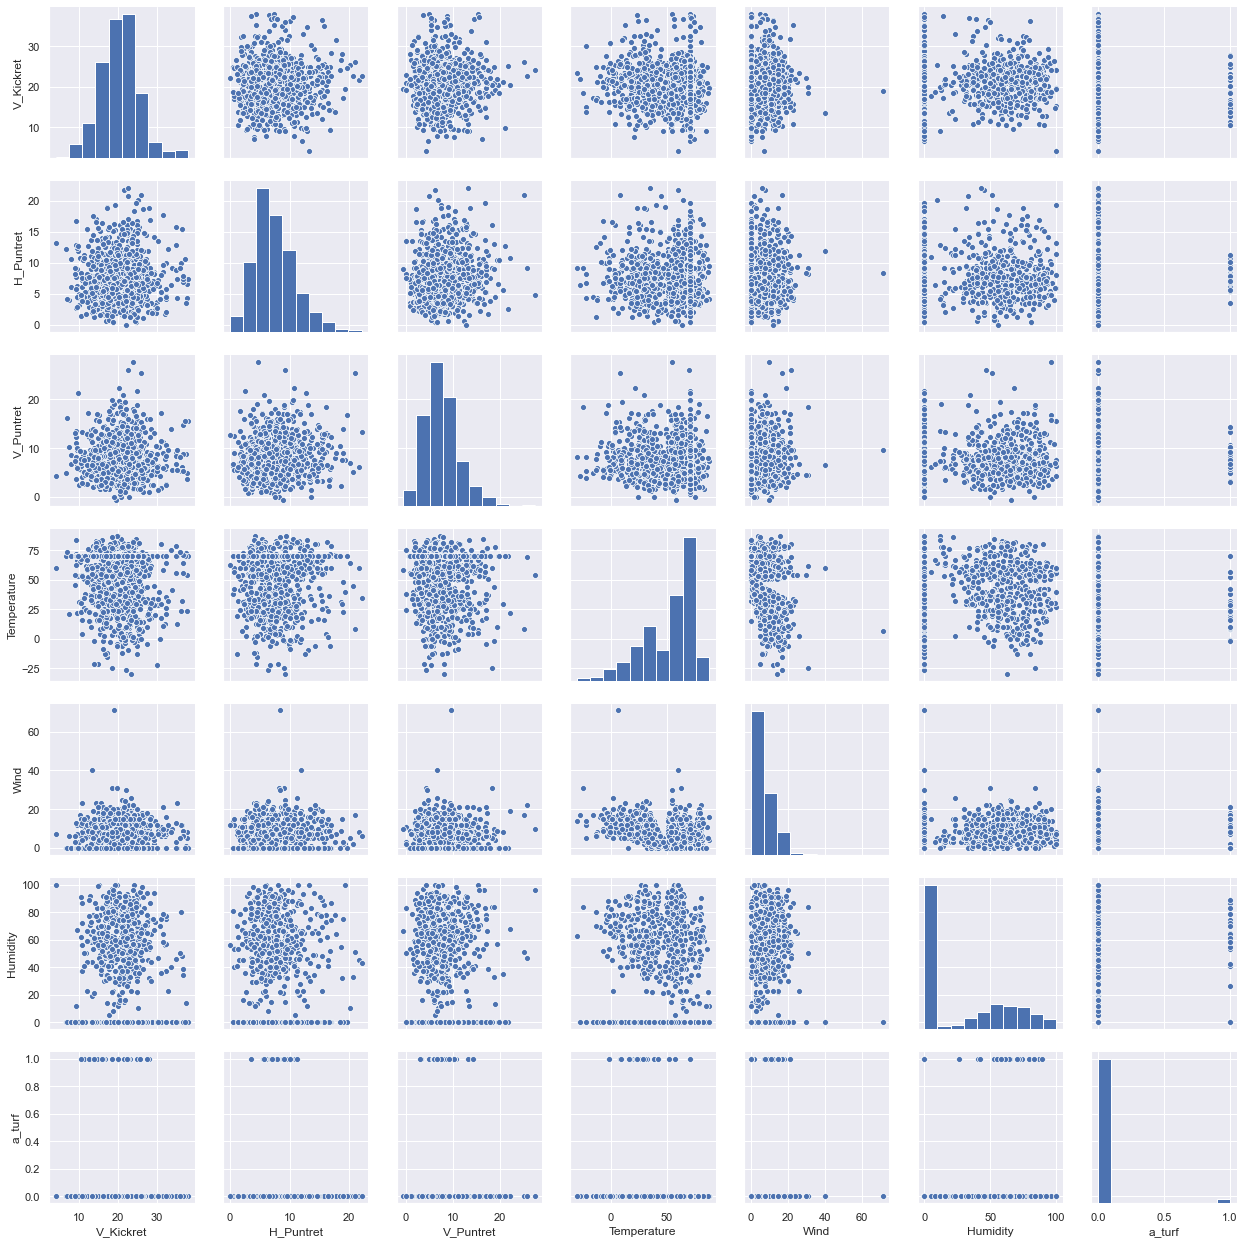

In [367]:
sns.pairplot(X_train.iloc[:,39:46])

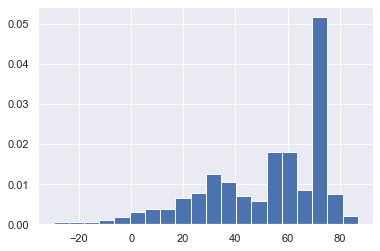

In [371]:
_ = plt.hist(((X_show['Temperature'])),bins=20,density=True)
plt.show()


In [361]:
X_show['Tot_Pts'].corr(np.exp(X_show['Temperature']))

0.0027547525663266597

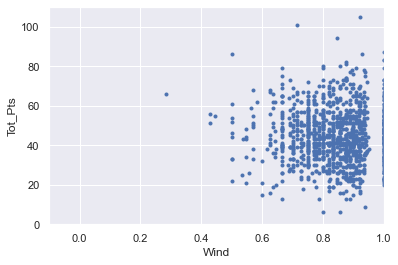

In [365]:
fig = plt.figure()
_ = fig.add_subplot(1,1,1)
_ = plt.xlabel('Wind')
_ = plt.ylabel('Tot_Pts')
_ = plt.xlim(-0.1)
_ = plt.ylim(0,110)
_ = plt.plot((X_show['H_FG_Pct']),X_show['Tot_Pts'],marker='.',linestyle='None')


In [368]:
X_show['Tot_Pts'].corr(X_show['Temperature'])

0.06631800608334214

In [178]:
X_show['Tot_Pts'].mean(),LR.intercept_

(44.888888888888886, 44.34477041641476)

In [264]:
factor=np.arange(0.0,0.75,0.05)
rmse=np.empty(len(factor))
for ind,n in enumerate(factor):
    path = 'data/df_working6_{:.2f}.pkl'.format(n)
    with open(path, 'rb') as f:
        df = pickle.load(f)
    df.dropna(inplace=True)

#    X = df.drop(['Tot_Pts','Over/Under','Home_Team','Vis_Team','H_Game','V_Game'],axis=1)
    X = df.drop(['Tot_Pts','Home_Team','Vis_Team','H_Game','V_Game'],axis=1)
    y = np.ravel(df['Tot_Pts'])
# 70% split for training data
    wtx_train, wtx_test, wty_train, wty_test = train_test_split(X, y, test_size = 1 - train_ratio, random_state = 77)
    wtx_val, wtx_test, wty_val, wty_test = train_test_split(wtx_test, wty_test,
                                                            test_size = test_ratio/(test_ratio + validation_ratio),
                                                            random_state=77)

    rob_train = robust.fit_transform(wtx_train)
    rob_test = robust.transform(wtx_test)
    LR.fit(rob_train,wty_train)
    ypred = LR.predict(rob_test)
    rmse[ind]=mean_squared_error(wty_test,ypred,squared=False)
print(rmse)

[13.32763008 13.32322027 13.35741153 13.36223151 13.38690777 13.43734733
 13.44698236 13.44850423 13.45405039 13.46045135 13.46782164 13.47900463
 13.48773173 13.48190433 13.48214518]


In [467]:
np.linspace(0.1,0.9,9)

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

In [469]:
grouped

In [533]:
# Over % for quantiles of Home Offensive Passing Yds
tile = np.arange(0.0,1.1,0.1)
#q_pass = np.empty(len(tile)-1)
q_pass = []
bins = [round(extest['H_Off_Pass'].quantile(p),1) for p in tile]
grouped = extest.groupby(pd.cut(extest['H_Off_Pass'],bins))
for key,item in grouped:
    q_pass.append((round(tile[bins.index(key.left)],1),
                   (item['Tot_Pts'] > item['Over/Under']).mean()))
q_pass

[(0.0, 0.5023255813953489),
 (0.1, 0.46788990825688076),
 (0.2, 0.5707762557077626),
 (0.3, 0.46153846153846156),
 (0.4, 0.4880382775119617),
 (0.5, 0.4885844748858447),
 (0.6, 0.4857142857142857),
 (0.7, 0.481651376146789),
 (0.8, 0.45871559633027525),
 (0.9, 0.5258215962441315)]

In [534]:
# Over % for quantiles of Home Points
tile = np.arange(0.0,1.1,0.1)
#q_pass = np.empty(len(tile)-1)
q_pts = []
bins = [round(extest['H_Pts'].quantile(p),1) for p in tile]
grouped = extest.groupby(pd.cut(extest['H_Pts'],bins))
for key,item in grouped:
    q_pts.append((round(tile[bins.index(key.left)],1),
                   (item['Tot_Pts'] > item['Over/Under']).mean()))
q_pts

[(0.0, 0.46402877697841727),
 (0.1, 0.5023474178403756),
 (0.2, 0.5265151515151515),
 (0.3, 0.5022222222222222),
 (0.4, 0.49523809523809526),
 (0.5, 0.5078125),
 (0.6, 0.5043859649122807),
 (0.7, 0.4713375796178344),
 (0.8, 0.4642857142857143),
 (0.9, 0.49740932642487046)]